# DivNoising - Prediction
This notebook contains an example on how to use a previously trained DivNoising VAE to denoise images.
If you haven't done so please first run ```0-CreateNoiseModel.ipynb``` and ```1-Training.ipynb```, which will download the data, create a noise model and train the DivNoising model.  

In [1]:
# We import all our dependencies.
import torch
import time
import sys
sys.path.append('../../')
from divnoising import utils
from nets import lightningmodel
from tifffile import imread
import numpy as np
import matplotlib.pyplot as plt
import math
device = torch.cuda.current_device()

# Load data to predict on
The data should be present in the directory specified by ```noisy_data_path``` and the ```noisy_input``` is the name of the image in this directory that needs to be denoised. 
This notebook expects 2D datasets in ```.tif``` format. If your data is a stack of 2D images, you can load it as shown in the next cell. If you dataset has multiple individual 2D tif files, comment out the second line in the cell below and uncomment the third line.

In [3]:
noisy_data_path="data/Mouse skull nuclei/"

noisy_input= imread('../../data/SDTrans/noise_200Hz_2400frames_pxlsize30nm_3.90dBSNR_24000x328x328.tif').astype(np.float32)
#Load the noisy data to be denoised

# load the first 1000 frames
noisy_input= noisy_input[:1000]
# noisy_input= imread(noisy_data_path+'*.tif').astype(np.float32) # To load multiple individual 2D tif images

# Load our model
We load the last weights of the trained model from the ```basedir```. The ```basedir``` should be the same which you specified in the training notebook `1-Training.ipynb`. Also specify the ```model_name```. It should be the same as specified in the training notebook `1-Training.ipynb`. 

In [3]:
%%capture
import torch
import numpy as np
import torch.serialization
from glob import glob

# 允许 numpy 类型（必须在 torch.load 前添加）
torch.serialization.add_safe_globals([
    np.dtype,
    np.core.multiarray.scalar,
    np.float32().dtype.__class__,
])

basedir = 'models'
model_name = 'divnoising_SDTrans_demo'

# 找 checkpoint
name = glob(basedir + "/" + model_name + '_best.ckpt')[0]
print(name)

# --------------------
# 手动加载 checkpoint（避免 Lightning 的 weights_only=True）
# --------------------
checkpoint = torch.load(name, map_location="cpu", weights_only=False)

# 创建模型实例（Lightning 保存的超参）
vae = lightningmodel.VAELightning(**checkpoint["hyper_parameters"])

# 加载 state_dict
vae.load_state_dict(checkpoint["state_dict"])

# 放到 GPU
if not torch.cuda.is_available():
    raise ValueError("GPU not found, predictions will run on CPU and can be somewhat slow!")
else:
    vae.to(device)


# Here we predict some qulitative diverse solutions

100%|██████████| 100/100 [00:00<00:00, 1063.40it/s]


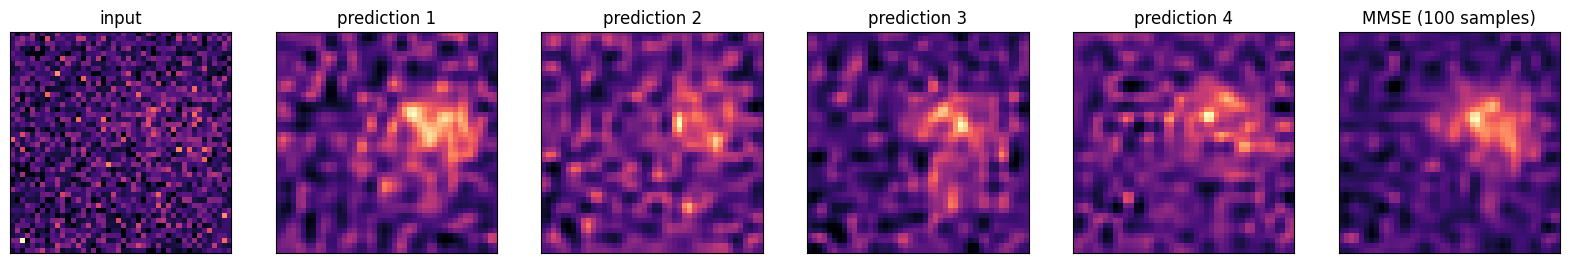

100%|██████████| 100/100 [00:00<00:00, 1957.63it/s]


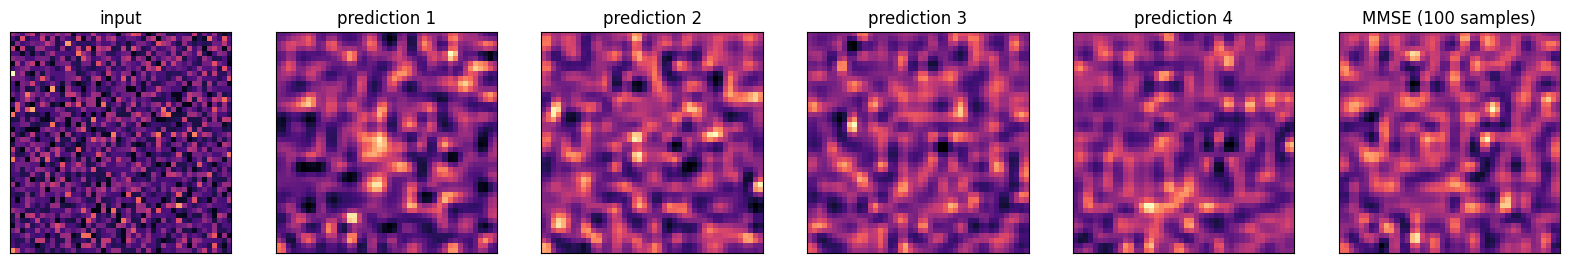

100%|██████████| 100/100 [00:00<00:00, 1918.76it/s]


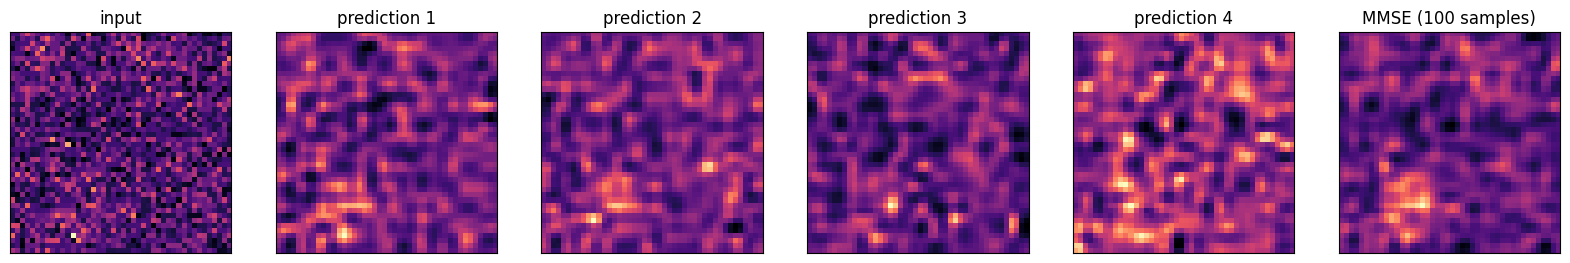

100%|██████████| 100/100 [00:00<00:00, 1953.15it/s]


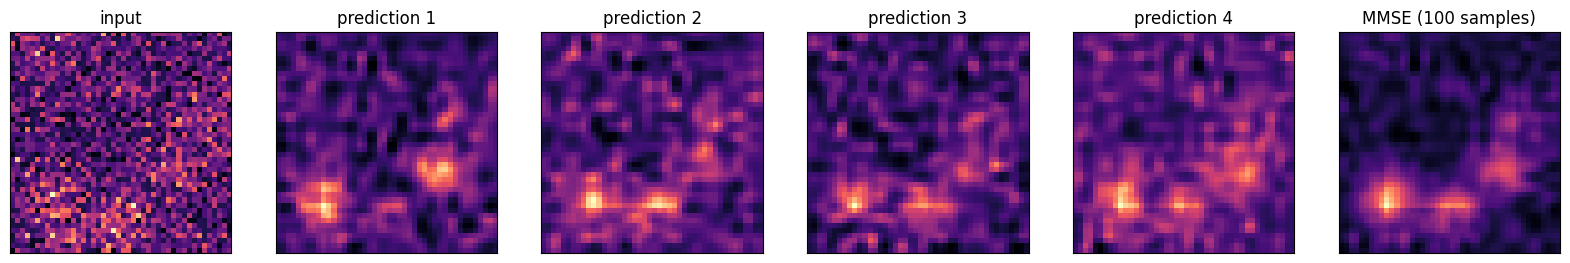

100%|██████████| 100/100 [00:00<00:00, 1919.80it/s]


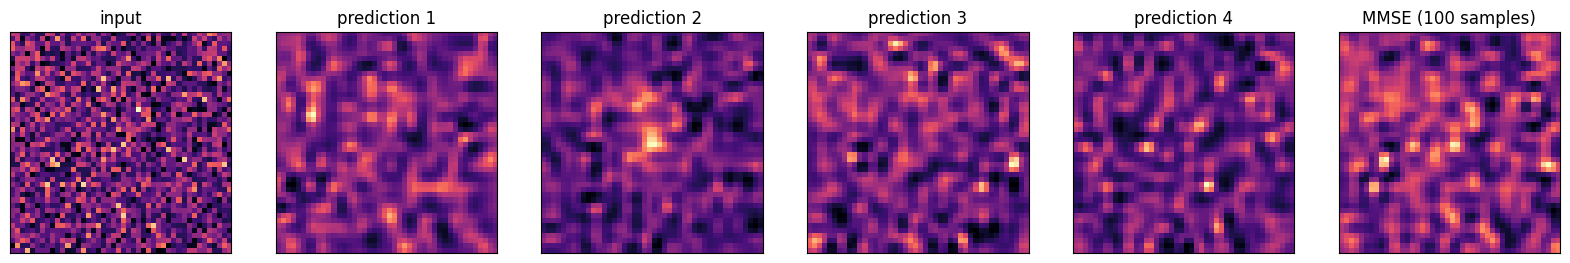

In [4]:
utils.plot_qualitative_results(noisy_input,vae,device)

# Predict denoised images and (optionally) save them
Specify how many denoised samples need to be predicted for each noisy image by specifying the parameter ```num_samples```. Also MMSE denoised estimate will be computed using these many samples.  

If you do not want access to different samples but just need the MMSE denoised estimate, set the paarmeter ```returnSamples=False```.

You can also save the denoised results (both samples and MMSE estimate for each noisy image) by providing the ```export_results_path``` which is the directory where the results should be saved.

Alternatively, you can also export the MMSE estimate and only a fraction of the samples used for computing MMSE estimate for each image by specifying the parameter ```fraction_sample_to_export```. If set to $0$, none of the samples are exported and only the MMSE estimate is exported, whereas setting it to $1$ exports all samples used for computing MMSE estimate.

If you only want to export MMSE estimate, set parameter ```export_mmse``` to True. If you do not want to export MMSE estimate, set it to ```False```.

The parameter ```tta``` refers to test time augmentation which may improve performance of DivNoising even further but will take ```8x``` longer to predict. This is enabled by default. If you wish to disable it, set it to ```False```.

In [12]:
num_samples = 10
export_results_path = "denoised_results"
fraction_samples_to_export = 0
export_mmse = True
tta = True
mmse_results = utils.predict_and_save(noisy_input,vae,num_samples,device,
                                fraction_samples_to_export,export_mmse,export_results_path,tta)

Processing image: 0


100%|██████████| 10/10 [00:00<00:00, 870.93it/s]


Processing image: 1


100%|██████████| 10/10 [00:00<00:00, 1116.07it/s]


Processing image: 2


100%|██████████| 10/10 [00:00<00:00, 1193.33it/s]


Processing image: 3


100%|██████████| 10/10 [00:00<00:00, 1237.18it/s]


Processing image: 4


100%|██████████| 10/10 [00:00<00:00, 1276.34it/s]


Processing image: 5


100%|██████████| 10/10 [00:00<00:00, 1212.65it/s]


Processing image: 6


100%|██████████| 10/10 [00:00<00:00, 1212.75it/s]


Processing image: 7


100%|██████████| 10/10 [00:00<00:00, 1202.67it/s]


Processing image: 8


100%|██████████| 10/10 [00:00<00:00, 1225.97it/s]


Processing image: 9


100%|██████████| 10/10 [00:00<00:00, 1271.43it/s]


Processing image: 10


100%|██████████| 10/10 [00:00<00:00, 1216.20it/s]


Processing image: 11


100%|██████████| 10/10 [00:00<00:00, 1214.19it/s]


Processing image: 12


100%|██████████| 10/10 [00:00<00:00, 1257.55it/s]


Processing image: 13


100%|██████████| 10/10 [00:00<00:00, 1226.80it/s]


Processing image: 14


100%|██████████| 10/10 [00:00<00:00, 1214.05it/s]


Processing image: 15


100%|██████████| 10/10 [00:00<00:00, 1184.93it/s]


Processing image: 16


100%|██████████| 10/10 [00:00<00:00, 1157.50it/s]


Processing image: 17


100%|██████████| 10/10 [00:00<00:00, 1194.38it/s]


Processing image: 18


100%|██████████| 10/10 [00:00<00:00, 1192.68it/s]


Processing image: 19


100%|██████████| 10/10 [00:00<00:00, 1216.94it/s]


Processing image: 20


100%|██████████| 10/10 [00:00<00:00, 1210.27it/s]


Processing image: 21


100%|██████████| 10/10 [00:00<00:00, 1224.65it/s]


Processing image: 22


100%|██████████| 10/10 [00:00<00:00, 1238.17it/s]


Processing image: 23


100%|██████████| 10/10 [00:00<00:00, 1222.54it/s]


Processing image: 24


100%|██████████| 10/10 [00:00<00:00, 1233.26it/s]


Processing image: 25


100%|██████████| 10/10 [00:00<00:00, 1253.00it/s]


Processing image: 26


100%|██████████| 10/10 [00:00<00:00, 1204.91it/s]


Processing image: 27


100%|██████████| 10/10 [00:00<00:00, 1270.27it/s]


Processing image: 28


100%|██████████| 10/10 [00:00<00:00, 1225.15it/s]


Processing image: 29


100%|██████████| 10/10 [00:00<00:00, 1247.71it/s]


Processing image: 30


100%|██████████| 10/10 [00:00<00:00, 1213.00it/s]


Processing image: 31


100%|██████████| 10/10 [00:00<00:00, 1206.09it/s]


Processing image: 32


100%|██████████| 10/10 [00:00<00:00, 1216.80it/s]


Processing image: 33


100%|██████████| 10/10 [00:00<00:00, 1221.94it/s]


Processing image: 34


100%|██████████| 10/10 [00:00<00:00, 1212.51it/s]


Processing image: 35


100%|██████████| 10/10 [00:00<00:00, 1215.92it/s]


Processing image: 36


100%|██████████| 10/10 [00:00<00:00, 1200.22it/s]


Processing image: 37


100%|██████████| 10/10 [00:00<00:00, 1209.64it/s]


Processing image: 38


100%|██████████| 10/10 [00:00<00:00, 1134.12it/s]


Processing image: 39


100%|██████████| 10/10 [00:00<00:00, 1200.95it/s]


Processing image: 40


100%|██████████| 10/10 [00:00<00:00, 1202.39it/s]


Processing image: 41


100%|██████████| 10/10 [00:00<00:00, 1209.95it/s]


Processing image: 42


100%|██████████| 10/10 [00:00<00:00, 1207.31it/s]


Processing image: 43


100%|██████████| 10/10 [00:00<00:00, 1210.69it/s]


Processing image: 44


100%|██████████| 10/10 [00:00<00:00, 1193.29it/s]


Processing image: 45


100%|██████████| 10/10 [00:00<00:00, 1184.53it/s]


Processing image: 46


100%|██████████| 10/10 [00:00<00:00, 1197.59it/s]


Processing image: 47


100%|██████████| 10/10 [00:00<00:00, 1196.83it/s]


Processing image: 48


100%|██████████| 10/10 [00:00<00:00, 1198.61it/s]


Processing image: 49


100%|██████████| 10/10 [00:00<00:00, 1202.50it/s]


Processing image: 50


100%|██████████| 10/10 [00:00<00:00, 1197.28it/s]


Processing image: 51


100%|██████████| 10/10 [00:00<00:00, 1198.20it/s]


Processing image: 52


100%|██████████| 10/10 [00:00<00:00, 1243.09it/s]


Processing image: 53


100%|██████████| 10/10 [00:00<00:00, 1208.49it/s]


Processing image: 54


100%|██████████| 10/10 [00:00<00:00, 1257.59it/s]


Processing image: 55


100%|██████████| 10/10 [00:00<00:00, 1069.76it/s]


Processing image: 56


100%|██████████| 10/10 [00:00<00:00, 1202.39it/s]


Processing image: 57


100%|██████████| 10/10 [00:00<00:00, 1206.26it/s]


Processing image: 58


100%|██████████| 10/10 [00:00<00:00, 1210.23it/s]


Processing image: 59


100%|██████████| 10/10 [00:00<00:00, 1203.84it/s]


Processing image: 60


100%|██████████| 10/10 [00:00<00:00, 1196.94it/s]


Processing image: 61


100%|██████████| 10/10 [00:00<00:00, 1192.41it/s]


Processing image: 62


100%|██████████| 10/10 [00:00<00:00, 1150.42it/s]


Processing image: 63


100%|██████████| 10/10 [00:00<00:00, 1196.36it/s]


Processing image: 64


100%|██████████| 10/10 [00:00<00:00, 1137.53it/s]


Processing image: 65


100%|██████████| 10/10 [00:00<00:00, 1180.53it/s]


Processing image: 66


100%|██████████| 10/10 [00:00<00:00, 1201.84it/s]


Processing image: 67


100%|██████████| 10/10 [00:00<00:00, 967.59it/s]


Processing image: 68


100%|██████████| 10/10 [00:00<00:00, 1172.31it/s]


Processing image: 69


100%|██████████| 10/10 [00:00<00:00, 1178.18it/s]


Processing image: 70


100%|██████████| 10/10 [00:00<00:00, 1017.05it/s]


Processing image: 71


100%|██████████| 10/10 [00:00<00:00, 1200.98it/s]


Processing image: 72


100%|██████████| 10/10 [00:00<00:00, 1202.12it/s]


Processing image: 73


100%|██████████| 10/10 [00:00<00:00, 1182.99it/s]


Processing image: 74


100%|██████████| 10/10 [00:00<00:00, 1216.23it/s]


Processing image: 75


100%|██████████| 10/10 [00:00<00:00, 1210.93it/s]


Processing image: 76


100%|██████████| 10/10 [00:00<00:00, 1217.36it/s]


Processing image: 77


100%|██████████| 10/10 [00:00<00:00, 1225.65it/s]


Processing image: 78


100%|██████████| 10/10 [00:00<00:00, 1010.89it/s]


Processing image: 79


100%|██████████| 10/10 [00:00<00:00, 1207.52it/s]


Processing image: 80


100%|██████████| 10/10 [00:00<00:00, 1186.04it/s]


Processing image: 81


100%|██████████| 10/10 [00:00<00:00, 1117.77it/s]


Processing image: 82


100%|██████████| 10/10 [00:00<00:00, 1158.81it/s]


Processing image: 83


100%|██████████| 10/10 [00:00<00:00, 1173.69it/s]


Processing image: 84


100%|██████████| 10/10 [00:00<00:00, 1181.83it/s]


Processing image: 85


100%|██████████| 10/10 [00:00<00:00, 1021.28it/s]


Processing image: 86


100%|██████████| 10/10 [00:00<00:00, 1018.21it/s]


Processing image: 87


100%|██████████| 10/10 [00:00<00:00, 1167.91it/s]


Processing image: 88


100%|██████████| 10/10 [00:00<00:00, 1176.03it/s]


Processing image: 89


100%|██████████| 10/10 [00:00<00:00, 1181.26it/s]


Processing image: 90


100%|██████████| 10/10 [00:00<00:00, 1174.05it/s]


Processing image: 91


100%|██████████| 10/10 [00:00<00:00, 1234.71it/s]


Processing image: 92


100%|██████████| 10/10 [00:00<00:00, 1228.70it/s]


Processing image: 93


100%|██████████| 10/10 [00:00<00:00, 1183.29it/s]


Processing image: 94


100%|██████████| 10/10 [00:00<00:00, 1193.05it/s]


Processing image: 95


100%|██████████| 10/10 [00:00<00:00, 1199.61it/s]


Processing image: 96


100%|██████████| 10/10 [00:00<00:00, 1111.10it/s]


Processing image: 97


100%|██████████| 10/10 [00:00<00:00, 1124.06it/s]


Processing image: 98


100%|██████████| 10/10 [00:00<00:00, 1209.26it/s]


Processing image: 99


100%|██████████| 10/10 [00:00<00:00, 1197.48it/s]


Processing image: 100


100%|██████████| 10/10 [00:00<00:00, 1197.24it/s]


Processing image: 101


100%|██████████| 10/10 [00:00<00:00, 1191.29it/s]


Processing image: 102


100%|██████████| 10/10 [00:00<00:00, 1248.16it/s]


Processing image: 103


100%|██████████| 10/10 [00:00<00:00, 1178.37it/s]


Processing image: 104


100%|██████████| 10/10 [00:00<00:00, 1191.73it/s]


Processing image: 105


100%|██████████| 10/10 [00:00<00:00, 1062.31it/s]


Processing image: 106


100%|██████████| 10/10 [00:00<00:00, 1192.34it/s]


Processing image: 107


100%|██████████| 10/10 [00:00<00:00, 1184.30it/s]


Processing image: 108


100%|██████████| 10/10 [00:00<00:00, 1200.16it/s]


Processing image: 109


100%|██████████| 10/10 [00:00<00:00, 1102.60it/s]


Processing image: 110


100%|██████████| 10/10 [00:00<00:00, 1181.53it/s]


Processing image: 111


100%|██████████| 10/10 [00:00<00:00, 1073.15it/s]


Processing image: 112


100%|██████████| 10/10 [00:00<00:00, 1164.86it/s]


Processing image: 113


100%|██████████| 10/10 [00:00<00:00, 1237.92it/s]


Processing image: 114


100%|██████████| 10/10 [00:00<00:00, 1204.46it/s]


Processing image: 115


100%|██████████| 10/10 [00:00<00:00, 1191.83it/s]


Processing image: 116


100%|██████████| 10/10 [00:00<00:00, 1201.91it/s]


Processing image: 117


100%|██████████| 10/10 [00:00<00:00, 1183.86it/s]


Processing image: 118


100%|██████████| 10/10 [00:00<00:00, 1179.63it/s]


Processing image: 119


100%|██████████| 10/10 [00:00<00:00, 1134.12it/s]


Processing image: 120


100%|██████████| 10/10 [00:00<00:00, 1248.42it/s]


Processing image: 121


100%|██████████| 10/10 [00:00<00:00, 1203.25it/s]


Processing image: 122


100%|██████████| 10/10 [00:00<00:00, 1187.75it/s]


Processing image: 123


100%|██████████| 10/10 [00:00<00:00, 1201.91it/s]


Processing image: 124


100%|██████████| 10/10 [00:00<00:00, 1204.22it/s]


Processing image: 125


100%|██████████| 10/10 [00:00<00:00, 1196.77it/s]


Processing image: 126


100%|██████████| 10/10 [00:00<00:00, 1200.67it/s]


Processing image: 127


100%|██████████| 10/10 [00:00<00:00, 1260.35it/s]


Processing image: 128


100%|██████████| 10/10 [00:00<00:00, 1185.10it/s]


Processing image: 129


100%|██████████| 10/10 [00:00<00:00, 1196.56it/s]


Processing image: 130


100%|██████████| 10/10 [00:00<00:00, 1206.99it/s]


Processing image: 131


100%|██████████| 10/10 [00:00<00:00, 1208.11it/s]


Processing image: 132


100%|██████████| 10/10 [00:00<00:00, 1196.70it/s]


Processing image: 133


100%|██████████| 10/10 [00:00<00:00, 1199.95it/s]


Processing image: 134


100%|██████████| 10/10 [00:00<00:00, 1114.88it/s]


Processing image: 135


100%|██████████| 10/10 [00:00<00:00, 1187.62it/s]


Processing image: 136


100%|██████████| 10/10 [00:00<00:00, 1246.41it/s]


Processing image: 137


100%|██████████| 10/10 [00:00<00:00, 1182.76it/s]


Processing image: 138


100%|██████████| 10/10 [00:00<00:00, 1202.60it/s]


Processing image: 139


100%|██████████| 10/10 [00:00<00:00, 1182.43it/s]


Processing image: 140


100%|██████████| 10/10 [00:00<00:00, 1163.11it/s]


Processing image: 141


100%|██████████| 10/10 [00:00<00:00, 1169.86it/s]


Processing image: 142


100%|██████████| 10/10 [00:00<00:00, 1179.53it/s]


Processing image: 143


100%|██████████| 10/10 [00:00<00:00, 1219.77it/s]


Processing image: 144


100%|██████████| 10/10 [00:00<00:00, 1200.43it/s]


Processing image: 145


100%|██████████| 10/10 [00:00<00:00, 1187.04it/s]


Processing image: 146


100%|██████████| 10/10 [00:00<00:00, 1181.00it/s]


Processing image: 147


100%|██████████| 10/10 [00:00<00:00, 1197.07it/s]


Processing image: 148


100%|██████████| 10/10 [00:00<00:00, 1176.92it/s]


Processing image: 149


100%|██████████| 10/10 [00:00<00:00, 1177.28it/s]


Processing image: 150


100%|██████████| 10/10 [00:00<00:00, 1197.18it/s]


Processing image: 151


100%|██████████| 10/10 [00:00<00:00, 1188.52it/s]


Processing image: 152


100%|██████████| 10/10 [00:00<00:00, 1181.00it/s]


Processing image: 153


100%|██████████| 10/10 [00:00<00:00, 1190.75it/s]


Processing image: 154


100%|██████████| 10/10 [00:00<00:00, 1185.57it/s]


Processing image: 155


100%|██████████| 10/10 [00:00<00:00, 1198.13it/s]


Processing image: 156


100%|██████████| 10/10 [00:00<00:00, 1206.09it/s]


Processing image: 157


100%|██████████| 10/10 [00:00<00:00, 1224.94it/s]


Processing image: 158


100%|██████████| 10/10 [00:00<00:00, 1189.50it/s]


Processing image: 159


100%|██████████| 10/10 [00:00<00:00, 1198.89it/s]


Processing image: 160


100%|██████████| 10/10 [00:00<00:00, 1195.33it/s]


Processing image: 161


100%|██████████| 10/10 [00:00<00:00, 1157.21it/s]


Processing image: 162


100%|██████████| 10/10 [00:00<00:00, 1177.48it/s]


Processing image: 163


100%|██████████| 10/10 [00:00<00:00, 1196.08it/s]


Processing image: 164


100%|██████████| 10/10 [00:00<00:00, 1242.54it/s]


Processing image: 165


100%|██████████| 10/10 [00:00<00:00, 1206.65it/s]


Processing image: 166


100%|██████████| 10/10 [00:00<00:00, 1201.94it/s]


Processing image: 167


100%|██████████| 10/10 [00:00<00:00, 1202.19it/s]


Processing image: 168


100%|██████████| 10/10 [00:00<00:00, 1238.43it/s]


Processing image: 169


100%|██████████| 10/10 [00:00<00:00, 1215.49it/s]


Processing image: 170


100%|██████████| 10/10 [00:00<00:00, 1209.40it/s]


Processing image: 171


100%|██████████| 10/10 [00:00<00:00, 1204.39it/s]


Processing image: 172


100%|██████████| 10/10 [00:00<00:00, 1244.90it/s]


Processing image: 173


100%|██████████| 10/10 [00:00<00:00, 1197.38it/s]


Processing image: 174


100%|██████████| 10/10 [00:00<00:00, 1178.24it/s]


Processing image: 175


100%|██████████| 10/10 [00:00<00:00, 1146.52it/s]


Processing image: 176


100%|██████████| 10/10 [00:00<00:00, 1191.46it/s]


Processing image: 177


100%|██████████| 10/10 [00:00<00:00, 1194.14it/s]


Processing image: 178


100%|██████████| 10/10 [00:00<00:00, 1195.47it/s]


Processing image: 179


100%|██████████| 10/10 [00:00<00:00, 1213.03it/s]


Processing image: 180


100%|██████████| 10/10 [00:00<00:00, 1149.03it/s]


Processing image: 181


100%|██████████| 10/10 [00:00<00:00, 1200.05it/s]


Processing image: 182


100%|██████████| 10/10 [00:00<00:00, 1233.26it/s]


Processing image: 183


100%|██████████| 10/10 [00:00<00:00, 1185.33it/s]


Processing image: 184


100%|██████████| 10/10 [00:00<00:00, 1189.30it/s]


Processing image: 185


100%|██████████| 10/10 [00:00<00:00, 1192.11it/s]


Processing image: 186


100%|██████████| 10/10 [00:00<00:00, 1196.56it/s]


Processing image: 187


100%|██████████| 10/10 [00:00<00:00, 1197.31it/s]


Processing image: 188


100%|██████████| 10/10 [00:00<00:00, 1206.16it/s]


Processing image: 189


100%|██████████| 10/10 [00:00<00:00, 1190.21it/s]


Processing image: 190


100%|██████████| 10/10 [00:00<00:00, 1184.76it/s]


Processing image: 191


100%|██████████| 10/10 [00:00<00:00, 1197.96it/s]


Processing image: 192


100%|██████████| 10/10 [00:00<00:00, 1197.89it/s]


Processing image: 193


100%|██████████| 10/10 [00:00<00:00, 1123.30it/s]


Processing image: 194


100%|██████████| 10/10 [00:00<00:00, 1214.30it/s]


Processing image: 195


100%|██████████| 10/10 [00:00<00:00, 1204.81it/s]


Processing image: 196


100%|██████████| 10/10 [00:00<00:00, 1119.26it/s]


Processing image: 197


100%|██████████| 10/10 [00:00<00:00, 1247.12it/s]


Processing image: 198


100%|██████████| 10/10 [00:00<00:00, 1243.13it/s]


Processing image: 199


100%|██████████| 10/10 [00:00<00:00, 1255.82it/s]


Processing image: 200


100%|██████████| 10/10 [00:00<00:00, 1247.45it/s]


Processing image: 201


100%|██████████| 10/10 [00:00<00:00, 1198.89it/s]


Processing image: 202


100%|██████████| 10/10 [00:00<00:00, 1183.90it/s]


Processing image: 203


100%|██████████| 10/10 [00:00<00:00, 1230.33it/s]


Processing image: 204


100%|██████████| 10/10 [00:00<00:00, 1235.58it/s]


Processing image: 205


100%|██████████| 10/10 [00:00<00:00, 1197.41it/s]


Processing image: 206


100%|██████████| 10/10 [00:00<00:00, 1231.92it/s]


Processing image: 207


100%|██████████| 10/10 [00:00<00:00, 1206.44it/s]


Processing image: 208


100%|██████████| 10/10 [00:00<00:00, 1266.55it/s]


Processing image: 209


100%|██████████| 10/10 [00:00<00:00, 1262.24it/s]


Processing image: 210


100%|██████████| 10/10 [00:00<00:00, 1207.10it/s]


Processing image: 211


100%|██████████| 10/10 [00:00<00:00, 1211.46it/s]


Processing image: 212


100%|██████████| 10/10 [00:00<00:00, 1264.64it/s]


Processing image: 213


100%|██████████| 10/10 [00:00<00:00, 1216.87it/s]


Processing image: 214


100%|██████████| 10/10 [00:00<00:00, 1178.54it/s]


Processing image: 215


100%|██████████| 10/10 [00:00<00:00, 1185.97it/s]


Processing image: 216


100%|██████████| 10/10 [00:00<00:00, 1206.89it/s]


Processing image: 217


100%|██████████| 10/10 [00:00<00:00, 1201.81it/s]


Processing image: 218


100%|██████████| 10/10 [00:00<00:00, 1208.25it/s]


Processing image: 219


100%|██████████| 10/10 [00:00<00:00, 1202.70it/s]


Processing image: 220


100%|██████████| 10/10 [00:00<00:00, 1196.83it/s]


Processing image: 221


100%|██████████| 10/10 [00:00<00:00, 1255.48it/s]


Processing image: 222


100%|██████████| 10/10 [00:00<00:00, 1205.81it/s]


Processing image: 223


100%|██████████| 10/10 [00:00<00:00, 1198.65it/s]


Processing image: 224


100%|██████████| 10/10 [00:00<00:00, 1211.46it/s]


Processing image: 225


100%|██████████| 10/10 [00:00<00:00, 1198.61it/s]


Processing image: 226


100%|██████████| 10/10 [00:00<00:00, 1202.60it/s]


Processing image: 227


100%|██████████| 10/10 [00:00<00:00, 1200.16it/s]


Processing image: 228


100%|██████████| 10/10 [00:00<00:00, 1245.93it/s]


Processing image: 229


100%|██████████| 10/10 [00:00<00:00, 1210.09it/s]


Processing image: 230


100%|██████████| 10/10 [00:00<00:00, 1200.60it/s]


Processing image: 231


100%|██████████| 10/10 [00:00<00:00, 1250.05it/s]


Processing image: 232


100%|██████████| 10/10 [00:00<00:00, 1204.91it/s]


Processing image: 233


100%|██████████| 10/10 [00:00<00:00, 1197.35it/s]


Processing image: 234


100%|██████████| 10/10 [00:00<00:00, 1199.85it/s]


Processing image: 235


100%|██████████| 10/10 [00:00<00:00, 1260.23it/s]


Processing image: 236


100%|██████████| 10/10 [00:00<00:00, 1207.06it/s]


Processing image: 237


100%|██████████| 10/10 [00:00<00:00, 1255.85it/s]


Processing image: 238


100%|██████████| 10/10 [00:00<00:00, 1202.87it/s]


Processing image: 239


100%|██████████| 10/10 [00:00<00:00, 1205.85it/s]


Processing image: 240


100%|██████████| 10/10 [00:00<00:00, 1227.27it/s]


Processing image: 241


100%|██████████| 10/10 [00:00<00:00, 1214.33it/s]


Processing image: 242


100%|██████████| 10/10 [00:00<00:00, 1229.28it/s]


Processing image: 243


100%|██████████| 10/10 [00:00<00:00, 1229.57it/s]


Processing image: 244


100%|██████████| 10/10 [00:00<00:00, 1238.32it/s]


Processing image: 245


100%|██████████| 10/10 [00:00<00:00, 1221.72it/s]


Processing image: 246


100%|██████████| 10/10 [00:00<00:00, 1227.12it/s]


Processing image: 247


100%|██████████| 10/10 [00:00<00:00, 1225.80it/s]


Processing image: 248


100%|██████████| 10/10 [00:00<00:00, 1211.56it/s]


Processing image: 249


100%|██████████| 10/10 [00:00<00:00, 1216.55it/s]


Processing image: 250


100%|██████████| 10/10 [00:00<00:00, 1215.78it/s]


Processing image: 251


100%|██████████| 10/10 [00:00<00:00, 1203.60it/s]


Processing image: 252


100%|██████████| 10/10 [00:00<00:00, 1237.99it/s]


Processing image: 253


100%|██████████| 10/10 [00:00<00:00, 1235.69it/s]


Processing image: 254


100%|██████████| 10/10 [00:00<00:00, 1236.67it/s]


Processing image: 255


100%|██████████| 10/10 [00:00<00:00, 1195.74it/s]


Processing image: 256


100%|██████████| 10/10 [00:00<00:00, 1246.34it/s]


Processing image: 257


100%|██████████| 10/10 [00:00<00:00, 1234.78it/s]


Processing image: 258


100%|██████████| 10/10 [00:00<00:00, 1254.20it/s]


Processing image: 259


100%|██████████| 10/10 [00:00<00:00, 1205.99it/s]


Processing image: 260


100%|██████████| 10/10 [00:00<00:00, 1203.25it/s]


Processing image: 261


100%|██████████| 10/10 [00:00<00:00, 1206.89it/s]


Processing image: 262


100%|██████████| 10/10 [00:00<00:00, 1200.53it/s]


Processing image: 263


100%|██████████| 10/10 [00:00<00:00, 1258.98it/s]


Processing image: 264


100%|██████████| 10/10 [00:00<00:00, 1189.57it/s]


Processing image: 265


100%|██████████| 10/10 [00:00<00:00, 1180.36it/s]


Processing image: 266


100%|██████████| 10/10 [00:00<00:00, 1223.58it/s]


Processing image: 267


100%|██████████| 10/10 [00:00<00:00, 1232.64it/s]


Processing image: 268


100%|██████████| 10/10 [00:00<00:00, 1231.88it/s]


Processing image: 269


100%|██████████| 10/10 [00:00<00:00, 1243.16it/s]


Processing image: 270


100%|██████████| 10/10 [00:00<00:00, 1244.64it/s]


Processing image: 271


100%|██████████| 10/10 [00:00<00:00, 1200.74it/s]


Processing image: 272


100%|██████████| 10/10 [00:00<00:00, 1184.93it/s]


Processing image: 273


100%|██████████| 10/10 [00:00<00:00, 1214.47it/s]


Processing image: 274


100%|██████████| 10/10 [00:00<00:00, 1225.65it/s]


Processing image: 275


100%|██████████| 10/10 [00:00<00:00, 1230.83it/s]


Processing image: 276


100%|██████████| 10/10 [00:00<00:00, 1231.66it/s]


Processing image: 277


100%|██████████| 10/10 [00:00<00:00, 1226.69it/s]


Processing image: 278


100%|██████████| 10/10 [00:00<00:00, 1225.54it/s]


Processing image: 279


100%|██████████| 10/10 [00:00<00:00, 1221.83it/s]


Processing image: 280


100%|██████████| 10/10 [00:00<00:00, 1214.82it/s]


Processing image: 281


100%|██████████| 10/10 [00:00<00:00, 1222.44it/s]


Processing image: 282


100%|██████████| 10/10 [00:00<00:00, 1222.51it/s]


Processing image: 283


100%|██████████| 10/10 [00:00<00:00, 1228.06it/s]


Processing image: 284


100%|██████████| 10/10 [00:00<00:00, 1231.19it/s]


Processing image: 285


100%|██████████| 10/10 [00:00<00:00, 1232.35it/s]


Processing image: 286


100%|██████████| 10/10 [00:00<00:00, 1196.77it/s]


Processing image: 287


100%|██████████| 10/10 [00:00<00:00, 1243.53it/s]


Processing image: 288


100%|██████████| 10/10 [00:00<00:00, 1205.09it/s]


Processing image: 289


100%|██████████| 10/10 [00:00<00:00, 1229.21it/s]


Processing image: 290


100%|██████████| 10/10 [00:00<00:00, 1228.78it/s]


Processing image: 291


100%|██████████| 10/10 [00:00<00:00, 1219.20it/s]


Processing image: 292


100%|██████████| 10/10 [00:00<00:00, 1225.80it/s]


Processing image: 293


100%|██████████| 10/10 [00:00<00:00, 1228.16it/s]


Processing image: 294


100%|██████████| 10/10 [00:00<00:00, 1215.42it/s]


Processing image: 295


100%|██████████| 10/10 [00:00<00:00, 1231.52it/s]


Processing image: 296


100%|██████████| 10/10 [00:00<00:00, 1234.89it/s]


Processing image: 297


100%|██████████| 10/10 [00:00<00:00, 1230.54it/s]


Processing image: 298


100%|██████████| 10/10 [00:00<00:00, 1220.87it/s]


Processing image: 299


100%|██████████| 10/10 [00:00<00:00, 1233.51it/s]


Processing image: 300


100%|██████████| 10/10 [00:00<00:00, 1220.09it/s]


Processing image: 301


100%|██████████| 10/10 [00:00<00:00, 1223.11it/s]


Processing image: 302


100%|██████████| 10/10 [00:00<00:00, 1225.62it/s]


Processing image: 303


100%|██████████| 10/10 [00:00<00:00, 1231.81it/s]


Processing image: 304


100%|██████████| 10/10 [00:00<00:00, 1219.56it/s]


Processing image: 305


100%|██████████| 10/10 [00:00<00:00, 1227.66it/s]


Processing image: 306


100%|██████████| 10/10 [00:00<00:00, 1227.12it/s]


Processing image: 307


100%|██████████| 10/10 [00:00<00:00, 1215.81it/s]


Processing image: 308


100%|██████████| 10/10 [00:00<00:00, 1224.33it/s]


Processing image: 309


100%|██████████| 10/10 [00:00<00:00, 1195.16it/s]


Processing image: 310


100%|██████████| 10/10 [00:00<00:00, 1220.34it/s]


Processing image: 311


100%|██████████| 10/10 [00:00<00:00, 1230.98it/s]


Processing image: 312


100%|██████████| 10/10 [00:00<00:00, 1214.65it/s]


Processing image: 313


100%|██████████| 10/10 [00:00<00:00, 1184.66it/s]


Processing image: 314


100%|██████████| 10/10 [00:00<00:00, 1235.95it/s]


Processing image: 315


100%|██████████| 10/10 [00:00<00:00, 1232.64it/s]


Processing image: 316


100%|██████████| 10/10 [00:00<00:00, 1215.00it/s]


Processing image: 317


100%|██████████| 10/10 [00:00<00:00, 1230.80it/s]


Processing image: 318


100%|██████████| 10/10 [00:00<00:00, 1224.47it/s]


Processing image: 319


100%|██████████| 10/10 [00:00<00:00, 1220.45it/s]


Processing image: 320


100%|██████████| 10/10 [00:00<00:00, 1224.26it/s]


Processing image: 321


100%|██████████| 10/10 [00:00<00:00, 1227.59it/s]


Processing image: 322


100%|██████████| 10/10 [00:00<00:00, 1197.38it/s]


Processing image: 323


100%|██████████| 10/10 [00:00<00:00, 1183.90it/s]


Processing image: 324


100%|██████████| 10/10 [00:00<00:00, 1246.86it/s]


Processing image: 325


100%|██████████| 10/10 [00:00<00:00, 1195.16it/s]


Processing image: 326


100%|██████████| 10/10 [00:00<00:00, 1204.71it/s]


Processing image: 327


100%|██████████| 10/10 [00:00<00:00, 1249.46it/s]


Processing image: 328


100%|██████████| 10/10 [00:00<00:00, 1193.63it/s]


Processing image: 329


100%|██████████| 10/10 [00:00<00:00, 1199.02it/s]


Processing image: 330


100%|██████████| 10/10 [00:00<00:00, 1206.82it/s]


Processing image: 331


100%|██████████| 10/10 [00:00<00:00, 1241.40it/s]


Processing image: 332


100%|██████████| 10/10 [00:00<00:00, 1193.97it/s]


Processing image: 333


100%|██████████| 10/10 [00:00<00:00, 1196.66it/s]


Processing image: 334


100%|██████████| 10/10 [00:00<00:00, 1248.90it/s]


Processing image: 335


100%|██████████| 10/10 [00:00<00:00, 1203.84it/s]


Processing image: 336


100%|██████████| 10/10 [00:00<00:00, 1196.70it/s]


Processing image: 337


100%|██████████| 10/10 [00:00<00:00, 1190.92it/s]


Processing image: 338


100%|██████████| 10/10 [00:00<00:00, 1216.41it/s]


Processing image: 339


100%|██████████| 10/10 [00:00<00:00, 1200.36it/s]


Processing image: 340


100%|██████████| 10/10 [00:00<00:00, 1204.36it/s]


Processing image: 341


100%|██████████| 10/10 [00:00<00:00, 1094.72it/s]


Processing image: 342


100%|██████████| 10/10 [00:00<00:00, 1206.33it/s]


Processing image: 343


100%|██████████| 10/10 [00:00<00:00, 1247.86it/s]


Processing image: 344


100%|██████████| 10/10 [00:00<00:00, 1209.47it/s]


Processing image: 345


100%|██████████| 10/10 [00:00<00:00, 1190.82it/s]


Processing image: 346


100%|██████████| 10/10 [00:00<00:00, 1204.95it/s]


Processing image: 347


100%|██████████| 10/10 [00:00<00:00, 1198.95it/s]


Processing image: 348


100%|██████████| 10/10 [00:00<00:00, 1191.83it/s]


Processing image: 349


100%|██████████| 10/10 [00:00<00:00, 1200.74it/s]


Processing image: 350


100%|██████████| 10/10 [00:00<00:00, 1186.34it/s]


Processing image: 351


100%|██████████| 10/10 [00:00<00:00, 1242.09it/s]


Processing image: 352


100%|██████████| 10/10 [00:00<00:00, 1202.74it/s]


Processing image: 353


100%|██████████| 10/10 [00:00<00:00, 1197.79it/s]


Processing image: 354


100%|██████████| 10/10 [00:00<00:00, 1150.20it/s]


Processing image: 355


100%|██████████| 10/10 [00:00<00:00, 1224.90it/s]


Processing image: 356


100%|██████████| 10/10 [00:00<00:00, 1071.78it/s]


Processing image: 357


100%|██████████| 10/10 [00:00<00:00, 1188.59it/s]


Processing image: 358


100%|██████████| 10/10 [00:00<00:00, 1194.65it/s]


Processing image: 359


100%|██████████| 10/10 [00:00<00:00, 1237.99it/s]


Processing image: 360


100%|██████████| 10/10 [00:00<00:00, 1229.10it/s]


Processing image: 361


100%|██████████| 10/10 [00:00<00:00, 1232.93it/s]


Processing image: 362


100%|██████████| 10/10 [00:00<00:00, 1241.07it/s]


Processing image: 363


100%|██████████| 10/10 [00:00<00:00, 1193.19it/s]


Processing image: 364


100%|██████████| 10/10 [00:00<00:00, 1197.11it/s]


Processing image: 365


100%|██████████| 10/10 [00:00<00:00, 1195.37it/s]


Processing image: 366


100%|██████████| 10/10 [00:00<00:00, 1198.72it/s]


Processing image: 367


100%|██████████| 10/10 [00:00<00:00, 1205.16it/s]


Processing image: 368


100%|██████████| 10/10 [00:00<00:00, 1207.90it/s]


Processing image: 369


100%|██████████| 10/10 [00:00<00:00, 1173.86it/s]


Processing image: 370


100%|██████████| 10/10 [00:00<00:00, 1184.70it/s]


Processing image: 371


100%|██████████| 10/10 [00:00<00:00, 1178.87it/s]


Processing image: 372


100%|██████████| 10/10 [00:00<00:00, 1183.93it/s]


Processing image: 373


100%|██████████| 10/10 [00:00<00:00, 1191.97it/s]


Processing image: 374


100%|██████████| 10/10 [00:00<00:00, 1195.30it/s]


Processing image: 375


100%|██████████| 10/10 [00:00<00:00, 1174.71it/s]


Processing image: 376


100%|██████████| 10/10 [00:00<00:00, 1186.10it/s]


Processing image: 377


100%|██████████| 10/10 [00:00<00:00, 1181.76it/s]


Processing image: 378


100%|██████████| 10/10 [00:00<00:00, 1225.94it/s]


Processing image: 379


100%|██████████| 10/10 [00:00<00:00, 1196.80it/s]


Processing image: 380


100%|██████████| 10/10 [00:00<00:00, 1200.46it/s]


Processing image: 381


100%|██████████| 10/10 [00:00<00:00, 1225.51it/s]


Processing image: 382


100%|██████████| 10/10 [00:00<00:00, 1202.29it/s]


Processing image: 383


100%|██████████| 10/10 [00:00<00:00, 1200.09it/s]


Processing image: 384


100%|██████████| 10/10 [00:00<00:00, 1205.36it/s]


Processing image: 385


100%|██████████| 10/10 [00:00<00:00, 1177.25it/s]


Processing image: 386


100%|██████████| 10/10 [00:00<00:00, 1197.96it/s]


Processing image: 387


100%|██████████| 10/10 [00:00<00:00, 1239.71it/s]


Processing image: 388


100%|██████████| 10/10 [00:00<00:00, 1111.16it/s]


Processing image: 389


100%|██████████| 10/10 [00:00<00:00, 1236.53it/s]


Processing image: 390


100%|██████████| 10/10 [00:00<00:00, 1233.11it/s]


Processing image: 391


100%|██████████| 10/10 [00:00<00:00, 1238.13it/s]


Processing image: 392


100%|██████████| 10/10 [00:00<00:00, 1247.45it/s]


Processing image: 393


100%|██████████| 10/10 [00:00<00:00, 1205.85it/s]


Processing image: 394


100%|██████████| 10/10 [00:00<00:00, 1204.12it/s]


Processing image: 395


100%|██████████| 10/10 [00:00<00:00, 1184.60it/s]


Processing image: 396


100%|██████████| 10/10 [00:00<00:00, 1193.26it/s]


Processing image: 397


100%|██████████| 10/10 [00:00<00:00, 1144.86it/s]


Processing image: 398


100%|██████████| 10/10 [00:00<00:00, 1193.05it/s]


Processing image: 399


100%|██████████| 10/10 [00:00<00:00, 1102.37it/s]


Processing image: 400


100%|██████████| 10/10 [00:00<00:00, 1187.25it/s]


Processing image: 401


100%|██████████| 10/10 [00:00<00:00, 1168.82it/s]


Processing image: 402


100%|██████████| 10/10 [00:00<00:00, 1188.09it/s]


Processing image: 403


100%|██████████| 10/10 [00:00<00:00, 1177.58it/s]


Processing image: 404


100%|██████████| 10/10 [00:00<00:00, 1166.54it/s]


Processing image: 405


100%|██████████| 10/10 [00:00<00:00, 1174.88it/s]


Processing image: 406


100%|██████████| 10/10 [00:00<00:00, 1152.79it/s]


Processing image: 407


100%|██████████| 10/10 [00:00<00:00, 1177.88it/s]


Processing image: 408


100%|██████████| 10/10 [00:00<00:00, 1153.96it/s]


Processing image: 409


100%|██████████| 10/10 [00:00<00:00, 1186.81it/s]


Processing image: 410


100%|██████████| 10/10 [00:00<00:00, 1183.36it/s]


Processing image: 411


100%|██████████| 10/10 [00:00<00:00, 1168.53it/s]


Processing image: 412


100%|██████████| 10/10 [00:00<00:00, 1172.81it/s]


Processing image: 413


100%|██████████| 10/10 [00:00<00:00, 1190.68it/s]


Processing image: 414


100%|██████████| 10/10 [00:00<00:00, 1166.51it/s]


Processing image: 415


100%|██████████| 10/10 [00:00<00:00, 1167.29it/s]


Processing image: 416


100%|██████████| 10/10 [00:00<00:00, 1195.64it/s]


Processing image: 417


100%|██████████| 10/10 [00:00<00:00, 1144.11it/s]


Processing image: 418


100%|██████████| 10/10 [00:00<00:00, 1173.86it/s]


Processing image: 419


100%|██████████| 10/10 [00:00<00:00, 1226.40it/s]


Processing image: 420


100%|██████████| 10/10 [00:00<00:00, 1206.26it/s]


Processing image: 421


100%|██████████| 10/10 [00:00<00:00, 1187.78it/s]


Processing image: 422


100%|██████████| 10/10 [00:00<00:00, 1240.44it/s]


Processing image: 423


100%|██████████| 10/10 [00:00<00:00, 1183.46it/s]


Processing image: 424


100%|██████████| 10/10 [00:00<00:00, 1210.44it/s]


Processing image: 425


100%|██████████| 10/10 [00:00<00:00, 1206.33it/s]


Processing image: 426


100%|██████████| 10/10 [00:00<00:00, 1202.94it/s]


Processing image: 427


100%|██████████| 10/10 [00:00<00:00, 1188.15it/s]


Processing image: 428


100%|██████████| 10/10 [00:00<00:00, 1071.23it/s]


Processing image: 429


100%|██████████| 10/10 [00:00<00:00, 1196.01it/s]


Processing image: 430


100%|██████████| 10/10 [00:00<00:00, 1194.72it/s]


Processing image: 431


100%|██████████| 10/10 [00:00<00:00, 1166.80it/s]


Processing image: 432


100%|██████████| 10/10 [00:00<00:00, 1210.30it/s]


Processing image: 433


100%|██████████| 10/10 [00:00<00:00, 1202.50it/s]


Processing image: 434


100%|██████████| 10/10 [00:00<00:00, 1186.00it/s]


Processing image: 435


100%|██████████| 10/10 [00:00<00:00, 1252.82it/s]


Processing image: 436


100%|██████████| 10/10 [00:00<00:00, 1201.39it/s]


Processing image: 437


100%|██████████| 10/10 [00:00<00:00, 1185.53it/s]


Processing image: 438


100%|██████████| 10/10 [00:00<00:00, 1206.79it/s]


Processing image: 439


100%|██████████| 10/10 [00:00<00:00, 1245.78it/s]


Processing image: 440


100%|██████████| 10/10 [00:00<00:00, 1201.01it/s]


Processing image: 441


100%|██████████| 10/10 [00:00<00:00, 1194.18it/s]


Processing image: 442


100%|██████████| 10/10 [00:00<00:00, 1204.78it/s]


Processing image: 443


100%|██████████| 10/10 [00:00<00:00, 1244.93it/s]


Processing image: 444


100%|██████████| 10/10 [00:00<00:00, 1250.09it/s]


Processing image: 445


100%|██████████| 10/10 [00:00<00:00, 1207.62it/s]


Processing image: 446


100%|██████████| 10/10 [00:00<00:00, 1118.42it/s]


Processing image: 447


100%|██████████| 10/10 [00:00<00:00, 1211.60it/s]


Processing image: 448


100%|██████████| 10/10 [00:00<00:00, 1188.22it/s]


Processing image: 449


100%|██████████| 10/10 [00:00<00:00, 1252.82it/s]


Processing image: 450


100%|██████████| 10/10 [00:00<00:00, 1197.41it/s]


Processing image: 451


100%|██████████| 10/10 [00:00<00:00, 1199.57it/s]


Processing image: 452


100%|██████████| 10/10 [00:00<00:00, 1209.99it/s]


Processing image: 453


100%|██████████| 10/10 [00:00<00:00, 1199.37it/s]


Processing image: 454


100%|██████████| 10/10 [00:00<00:00, 1251.66it/s]


Processing image: 455


100%|██████████| 10/10 [00:00<00:00, 1194.89it/s]


Processing image: 456


100%|██████████| 10/10 [00:00<00:00, 1192.17it/s]


Processing image: 457


100%|██████████| 10/10 [00:00<00:00, 1210.58it/s]


Processing image: 458


100%|██████████| 10/10 [00:00<00:00, 1204.08it/s]


Processing image: 459


100%|██████████| 10/10 [00:00<00:00, 1189.84it/s]


Processing image: 460


100%|██████████| 10/10 [00:00<00:00, 1202.39it/s]


Processing image: 461


100%|██████████| 10/10 [00:00<00:00, 1182.79it/s]


Processing image: 462


100%|██████████| 10/10 [00:00<00:00, 1195.81it/s]


Processing image: 463


100%|██████████| 10/10 [00:00<00:00, 1212.51it/s]


Processing image: 464


100%|██████████| 10/10 [00:00<00:00, 1191.83it/s]


Processing image: 465


100%|██████████| 10/10 [00:00<00:00, 1192.27it/s]


Processing image: 466


100%|██████████| 10/10 [00:00<00:00, 1201.57it/s]


Processing image: 467


100%|██████████| 10/10 [00:00<00:00, 1199.98it/s]


Processing image: 468


100%|██████████| 10/10 [00:00<00:00, 1220.16it/s]


Processing image: 469


100%|██████████| 10/10 [00:00<00:00, 1180.73it/s]


Processing image: 470


100%|██████████| 10/10 [00:00<00:00, 1202.87it/s]


Processing image: 471


100%|██████████| 10/10 [00:00<00:00, 1253.98it/s]


Processing image: 472


100%|██████████| 10/10 [00:00<00:00, 1198.72it/s]


Processing image: 473


100%|██████████| 10/10 [00:00<00:00, 1191.39it/s]


Processing image: 474


100%|██████████| 10/10 [00:00<00:00, 1231.45it/s]


Processing image: 475


100%|██████████| 10/10 [00:00<00:00, 1234.71it/s]


Processing image: 476


100%|██████████| 10/10 [00:00<00:00, 1233.40it/s]


Processing image: 477


100%|██████████| 10/10 [00:00<00:00, 1201.77it/s]


Processing image: 478


100%|██████████| 10/10 [00:00<00:00, 1189.77it/s]


Processing image: 479


100%|██████████| 10/10 [00:00<00:00, 1205.26it/s]


Processing image: 480


100%|██████████| 10/10 [00:00<00:00, 1194.82it/s]


Processing image: 481


100%|██████████| 10/10 [00:00<00:00, 1205.64it/s]


Processing image: 482


100%|██████████| 10/10 [00:00<00:00, 1199.19it/s]


Processing image: 483


100%|██████████| 10/10 [00:00<00:00, 1185.10it/s]


Processing image: 484


100%|██████████| 10/10 [00:00<00:00, 1193.94it/s]


Processing image: 485


100%|██████████| 10/10 [00:00<00:00, 1195.26it/s]


Processing image: 486


100%|██████████| 10/10 [00:00<00:00, 1194.52it/s]


Processing image: 487


100%|██████████| 10/10 [00:00<00:00, 1199.19it/s]


Processing image: 488


100%|██████████| 10/10 [00:00<00:00, 1194.31it/s]


Processing image: 489


100%|██████████| 10/10 [00:00<00:00, 1193.33it/s]


Processing image: 490


100%|██████████| 10/10 [00:00<00:00, 1237.18it/s]


Processing image: 491


100%|██████████| 10/10 [00:00<00:00, 1242.90it/s]


Processing image: 492


100%|██████████| 10/10 [00:00<00:00, 1228.56it/s]


Processing image: 493


100%|██████████| 10/10 [00:00<00:00, 1116.31it/s]


Processing image: 494


100%|██████████| 10/10 [00:00<00:00, 1233.29it/s]


Processing image: 495


100%|██████████| 10/10 [00:00<00:00, 1249.72it/s]


Processing image: 496


100%|██████████| 10/10 [00:00<00:00, 1199.16it/s]


Processing image: 497


100%|██████████| 10/10 [00:00<00:00, 1221.80it/s]


Processing image: 498


100%|██████████| 10/10 [00:00<00:00, 1172.35it/s]


Processing image: 499


100%|██████████| 10/10 [00:00<00:00, 1187.01it/s]


Processing image: 500


100%|██████████| 10/10 [00:00<00:00, 1199.64it/s]


Processing image: 501


100%|██████████| 10/10 [00:00<00:00, 1200.81it/s]


Processing image: 502


100%|██████████| 10/10 [00:00<00:00, 1196.19it/s]


Processing image: 503


100%|██████████| 10/10 [00:00<00:00, 1241.40it/s]


Processing image: 504


100%|██████████| 10/10 [00:00<00:00, 1202.19it/s]


Processing image: 505


100%|██████████| 10/10 [00:00<00:00, 1200.02it/s]


Processing image: 506


100%|██████████| 10/10 [00:00<00:00, 1243.68it/s]


Processing image: 507


100%|██████████| 10/10 [00:00<00:00, 1132.16it/s]


Processing image: 508


100%|██████████| 10/10 [00:00<00:00, 1258.76it/s]


Processing image: 509


100%|██████████| 10/10 [00:00<00:00, 1181.33it/s]


Processing image: 510


100%|██████████| 10/10 [00:00<00:00, 1204.95it/s]


Processing image: 511


100%|██████████| 10/10 [00:00<00:00, 1219.20it/s]


Processing image: 512


100%|██████████| 10/10 [00:00<00:00, 1194.69it/s]


Processing image: 513


100%|██████████| 10/10 [00:00<00:00, 1198.92it/s]


Processing image: 514


100%|██████████| 10/10 [00:00<00:00, 1210.06it/s]


Processing image: 515


100%|██████████| 10/10 [00:00<00:00, 1190.95it/s]


Processing image: 516


100%|██████████| 10/10 [00:00<00:00, 1203.84it/s]


Processing image: 517


100%|██████████| 10/10 [00:00<00:00, 1184.90it/s]


Processing image: 518


100%|██████████| 10/10 [00:00<00:00, 1215.18it/s]


Processing image: 519


100%|██████████| 10/10 [00:00<00:00, 1190.82it/s]


Processing image: 520


100%|██████████| 10/10 [00:00<00:00, 1196.56it/s]


Processing image: 521


100%|██████████| 10/10 [00:00<00:00, 1149.60it/s]


Processing image: 522


100%|██████████| 10/10 [00:00<00:00, 1221.30it/s]


Processing image: 523


100%|██████████| 10/10 [00:00<00:00, 1222.62it/s]


Processing image: 524


100%|██████████| 10/10 [00:00<00:00, 1184.56it/s]


Processing image: 525


100%|██████████| 10/10 [00:00<00:00, 1242.94it/s]


Processing image: 526


100%|██████████| 10/10 [00:00<00:00, 1162.89it/s]


Processing image: 527


100%|██████████| 10/10 [00:00<00:00, 1194.01it/s]


Processing image: 528


100%|██████████| 10/10 [00:00<00:00, 1148.21it/s]


Processing image: 529


100%|██████████| 10/10 [00:00<00:00, 1194.79it/s]


Processing image: 530


100%|██████████| 10/10 [00:00<00:00, 1199.50it/s]


Processing image: 531


100%|██████████| 10/10 [00:00<00:00, 1128.38it/s]


Processing image: 532


100%|██████████| 10/10 [00:00<00:00, 1180.46it/s]


Processing image: 533


100%|██████████| 10/10 [00:00<00:00, 1200.64it/s]


Processing image: 534


100%|██████████| 10/10 [00:00<00:00, 1160.73it/s]


Processing image: 535


100%|██████████| 10/10 [00:00<00:00, 1171.99it/s]


Processing image: 536


100%|██████████| 10/10 [00:00<00:00, 1202.77it/s]


Processing image: 537


100%|██████████| 10/10 [00:00<00:00, 1203.46it/s]


Processing image: 538


100%|██████████| 10/10 [00:00<00:00, 1189.67it/s]


Processing image: 539


100%|██████████| 10/10 [00:00<00:00, 1196.83it/s]


Processing image: 540


100%|██████████| 10/10 [00:00<00:00, 1208.38it/s]


Processing image: 541


100%|██████████| 10/10 [00:00<00:00, 1207.34it/s]


Processing image: 542


100%|██████████| 10/10 [00:00<00:00, 1212.05it/s]


Processing image: 543


100%|██████████| 10/10 [00:00<00:00, 1206.51it/s]


Processing image: 544


100%|██████████| 10/10 [00:00<00:00, 1203.36it/s]


Processing image: 545


100%|██████████| 10/10 [00:00<00:00, 1197.52it/s]


Processing image: 546


100%|██████████| 10/10 [00:00<00:00, 1198.00it/s]


Processing image: 547


100%|██████████| 10/10 [00:00<00:00, 1203.08it/s]


Processing image: 548


100%|██████████| 10/10 [00:00<00:00, 1204.12it/s]


Processing image: 549


100%|██████████| 10/10 [00:00<00:00, 1190.31it/s]


Processing image: 550


100%|██████████| 10/10 [00:00<00:00, 1207.48it/s]


Processing image: 551


100%|██████████| 10/10 [00:00<00:00, 1214.68it/s]


Processing image: 552


100%|██████████| 10/10 [00:00<00:00, 1190.85it/s]


Processing image: 553


100%|██████████| 10/10 [00:00<00:00, 1197.55it/s]


Processing image: 554


100%|██████████| 10/10 [00:00<00:00, 1226.05it/s]


Processing image: 555


100%|██████████| 10/10 [00:00<00:00, 1236.82it/s]


Processing image: 556


100%|██████████| 10/10 [00:00<00:00, 1228.67it/s]


Processing image: 557


100%|██████████| 10/10 [00:00<00:00, 1210.72it/s]


Processing image: 558


100%|██████████| 10/10 [00:00<00:00, 1244.53it/s]


Processing image: 559


100%|██████████| 10/10 [00:00<00:00, 1147.90it/s]


Processing image: 560


100%|██████████| 10/10 [00:00<00:00, 1239.31it/s]


Processing image: 561


100%|██████████| 10/10 [00:00<00:00, 1202.87it/s]


Processing image: 562


100%|██████████| 10/10 [00:00<00:00, 1176.09it/s]


Processing image: 563


100%|██████████| 10/10 [00:00<00:00, 1131.85it/s]


Processing image: 564


100%|██████████| 10/10 [00:00<00:00, 1239.85it/s]


Processing image: 565


100%|██████████| 10/10 [00:00<00:00, 1200.81it/s]


Processing image: 566


100%|██████████| 10/10 [00:00<00:00, 1199.85it/s]


Processing image: 567


100%|██████████| 10/10 [00:00<00:00, 1197.62it/s]


Processing image: 568


100%|██████████| 10/10 [00:00<00:00, 1238.24it/s]


Processing image: 569


100%|██████████| 10/10 [00:00<00:00, 1203.32it/s]


Processing image: 570


100%|██████████| 10/10 [00:00<00:00, 1199.50it/s]


Processing image: 571


100%|██████████| 10/10 [00:00<00:00, 1249.76it/s]


Processing image: 572


100%|██████████| 10/10 [00:00<00:00, 1201.26it/s]


Processing image: 573


100%|██████████| 10/10 [00:00<00:00, 1192.61it/s]


Processing image: 574


100%|██████████| 10/10 [00:00<00:00, 1248.23it/s]


Processing image: 575


100%|██████████| 10/10 [00:00<00:00, 1235.47it/s]


Processing image: 576


100%|██████████| 10/10 [00:00<00:00, 1243.79it/s]


Processing image: 577


100%|██████████| 10/10 [00:00<00:00, 1245.08it/s]


Processing image: 578


100%|██████████| 10/10 [00:00<00:00, 1213.28it/s]


Processing image: 579


100%|██████████| 10/10 [00:00<00:00, 1200.67it/s]


Processing image: 580


100%|██████████| 10/10 [00:00<00:00, 1197.69it/s]


Processing image: 581


100%|██████████| 10/10 [00:00<00:00, 1219.63it/s]


Processing image: 582


100%|██████████| 10/10 [00:00<00:00, 1158.46it/s]


Processing image: 583


100%|██████████| 10/10 [00:00<00:00, 1194.79it/s]


Processing image: 584


100%|██████████| 10/10 [00:00<00:00, 1215.74it/s]


Processing image: 585


100%|██████████| 10/10 [00:00<00:00, 1201.91it/s]


Processing image: 586


100%|██████████| 10/10 [00:00<00:00, 1141.31it/s]


Processing image: 587


100%|██████████| 10/10 [00:00<00:00, 1207.52it/s]


Processing image: 588


100%|██████████| 10/10 [00:00<00:00, 1191.90it/s]


Processing image: 589


100%|██████████| 10/10 [00:00<00:00, 1204.12it/s]


Processing image: 590


100%|██████████| 10/10 [00:00<00:00, 1204.01it/s]


Processing image: 591


100%|██████████| 10/10 [00:00<00:00, 1199.43it/s]


Processing image: 592


100%|██████████| 10/10 [00:00<00:00, 1247.67it/s]


Processing image: 593


100%|██████████| 10/10 [00:00<00:00, 1203.08it/s]


Processing image: 594


100%|██████████| 10/10 [00:00<00:00, 1200.67it/s]


Processing image: 595


100%|██████████| 10/10 [00:00<00:00, 1212.65it/s]


Processing image: 596


100%|██████████| 10/10 [00:00<00:00, 1145.33it/s]


Processing image: 597


100%|██████████| 10/10 [00:00<00:00, 1195.84it/s]


Processing image: 598


100%|██████████| 10/10 [00:00<00:00, 1193.12it/s]


Processing image: 599


100%|██████████| 10/10 [00:00<00:00, 1180.40it/s]


Processing image: 600


100%|██████████| 10/10 [00:00<00:00, 1193.56it/s]


Processing image: 601


100%|██████████| 10/10 [00:00<00:00, 1178.97it/s]


Processing image: 602


100%|██████████| 10/10 [00:00<00:00, 1211.60it/s]


Processing image: 603


100%|██████████| 10/10 [00:00<00:00, 1193.19it/s]


Processing image: 604


100%|██████████| 10/10 [00:00<00:00, 1202.46it/s]


Processing image: 605


100%|██████████| 10/10 [00:00<00:00, 1191.33it/s]


Processing image: 606


100%|██████████| 10/10 [00:00<00:00, 1192.78it/s]


Processing image: 607


100%|██████████| 10/10 [00:00<00:00, 1205.40it/s]


Processing image: 608


100%|██████████| 10/10 [00:00<00:00, 1175.24it/s]


Processing image: 609


100%|██████████| 10/10 [00:00<00:00, 1194.14it/s]


Processing image: 610


100%|██████████| 10/10 [00:00<00:00, 1194.01it/s]


Processing image: 611


100%|██████████| 10/10 [00:00<00:00, 1184.00it/s]


Processing image: 612


100%|██████████| 10/10 [00:00<00:00, 1196.66it/s]


Processing image: 613


100%|██████████| 10/10 [00:00<00:00, 1193.67it/s]


Processing image: 614


100%|██████████| 10/10 [00:00<00:00, 1186.37it/s]


Processing image: 615


100%|██████████| 10/10 [00:00<00:00, 1199.71it/s]


Processing image: 616


100%|██████████| 10/10 [00:00<00:00, 1187.11it/s]


Processing image: 617


100%|██████████| 10/10 [00:00<00:00, 1184.80it/s]


Processing image: 618


100%|██████████| 10/10 [00:00<00:00, 1188.76it/s]


Processing image: 619


100%|██████████| 10/10 [00:00<00:00, 1196.70it/s]


Processing image: 620


100%|██████████| 10/10 [00:00<00:00, 1173.20it/s]


Processing image: 621


100%|██████████| 10/10 [00:00<00:00, 1179.77it/s]


Processing image: 622


100%|██████████| 10/10 [00:00<00:00, 1186.34it/s]


Processing image: 623


100%|██████████| 10/10 [00:00<00:00, 1214.12it/s]


Processing image: 624


100%|██████████| 10/10 [00:00<00:00, 1199.95it/s]


Processing image: 625


100%|██████████| 10/10 [00:00<00:00, 1175.01it/s]


Processing image: 626


100%|██████████| 10/10 [00:00<00:00, 1189.64it/s]


Processing image: 627


100%|██████████| 10/10 [00:00<00:00, 1142.58it/s]


Processing image: 628


100%|██████████| 10/10 [00:00<00:00, 1171.30it/s]


Processing image: 629


100%|██████████| 10/10 [00:00<00:00, 1189.70it/s]


Processing image: 630


100%|██████████| 10/10 [00:00<00:00, 1177.75it/s]


Processing image: 631


100%|██████████| 10/10 [00:00<00:00, 1179.37it/s]


Processing image: 632


100%|██████████| 10/10 [00:00<00:00, 1183.93it/s]


Processing image: 633


100%|██████████| 10/10 [00:00<00:00, 1177.32it/s]


Processing image: 634


100%|██████████| 10/10 [00:00<00:00, 1173.23it/s]


Processing image: 635


100%|██████████| 10/10 [00:00<00:00, 1173.10it/s]


Processing image: 636


100%|██████████| 10/10 [00:00<00:00, 1199.64it/s]


Processing image: 637


100%|██████████| 10/10 [00:00<00:00, 1061.74it/s]


Processing image: 638


100%|██████████| 10/10 [00:00<00:00, 1200.22it/s]


Processing image: 639


100%|██████████| 10/10 [00:00<00:00, 1179.00it/s]


Processing image: 640


100%|██████████| 10/10 [00:00<00:00, 1209.19it/s]


Processing image: 641


100%|██████████| 10/10 [00:00<00:00, 1205.99it/s]


Processing image: 642


100%|██████████| 10/10 [00:00<00:00, 1181.23it/s]


Processing image: 643


100%|██████████| 10/10 [00:00<00:00, 1201.12it/s]


Processing image: 644


100%|██████████| 10/10 [00:00<00:00, 1203.84it/s]


Processing image: 645


100%|██████████| 10/10 [00:00<00:00, 1204.08it/s]


Processing image: 646


100%|██████████| 10/10 [00:00<00:00, 1201.84it/s]


Processing image: 647


100%|██████████| 10/10 [00:00<00:00, 1198.24it/s]


Processing image: 648


100%|██████████| 10/10 [00:00<00:00, 1249.98it/s]


Processing image: 649


100%|██████████| 10/10 [00:00<00:00, 1174.74it/s]


Processing image: 650


100%|██████████| 10/10 [00:00<00:00, 1204.26it/s]


Processing image: 651


100%|██████████| 10/10 [00:00<00:00, 1216.09it/s]


Processing image: 652


100%|██████████| 10/10 [00:00<00:00, 1209.26it/s]


Processing image: 653


100%|██████████| 10/10 [00:00<00:00, 1199.37it/s]


Processing image: 654


100%|██████████| 10/10 [00:00<00:00, 1256.53it/s]


Processing image: 655


100%|██████████| 10/10 [00:00<00:00, 1206.23it/s]


Processing image: 656


100%|██████████| 10/10 [00:00<00:00, 1238.72it/s]


Processing image: 657


100%|██████████| 10/10 [00:00<00:00, 1034.69it/s]


Processing image: 658


100%|██████████| 10/10 [00:00<00:00, 1212.05it/s]


Processing image: 659


100%|██████████| 10/10 [00:00<00:00, 1064.33it/s]


Processing image: 660


100%|██████████| 10/10 [00:00<00:00, 1206.99it/s]


Processing image: 661


100%|██████████| 10/10 [00:00<00:00, 1215.81it/s]


Processing image: 662


100%|██████████| 10/10 [00:00<00:00, 1205.68it/s]


Processing image: 663


100%|██████████| 10/10 [00:00<00:00, 1211.88it/s]


Processing image: 664


100%|██████████| 10/10 [00:00<00:00, 1204.33it/s]


Processing image: 665


100%|██████████| 10/10 [00:00<00:00, 1187.08it/s]


Processing image: 666


100%|██████████| 10/10 [00:00<00:00, 1213.03it/s]


Processing image: 667


100%|██████████| 10/10 [00:00<00:00, 1058.74it/s]


Processing image: 668


100%|██████████| 10/10 [00:00<00:00, 1201.22it/s]


Processing image: 669


100%|██████████| 10/10 [00:00<00:00, 1181.93it/s]


Processing image: 670


100%|██████████| 10/10 [00:00<00:00, 1253.19it/s]


Processing image: 671


100%|██████████| 10/10 [00:00<00:00, 1210.55it/s]


Processing image: 672


100%|██████████| 10/10 [00:00<00:00, 1214.23it/s]


Processing image: 673


100%|██████████| 10/10 [00:00<00:00, 1166.19it/s]


Processing image: 674


100%|██████████| 10/10 [00:00<00:00, 1202.08it/s]


Processing image: 675


100%|██████████| 10/10 [00:00<00:00, 1209.64it/s]


Processing image: 676


100%|██████████| 10/10 [00:00<00:00, 1199.85it/s]


Processing image: 677


100%|██████████| 10/10 [00:00<00:00, 1218.00it/s]


Processing image: 678


100%|██████████| 10/10 [00:00<00:00, 1130.08it/s]


Processing image: 679


100%|██████████| 10/10 [00:00<00:00, 1228.45it/s]


Processing image: 680


100%|██████████| 10/10 [00:00<00:00, 1208.11it/s]


Processing image: 681


100%|██████████| 10/10 [00:00<00:00, 1252.97it/s]


Processing image: 682


100%|██████████| 10/10 [00:00<00:00, 1206.61it/s]


Processing image: 683


100%|██████████| 10/10 [00:00<00:00, 1187.95it/s]


Processing image: 684


100%|██████████| 10/10 [00:00<00:00, 1201.01it/s]


Processing image: 685


100%|██████████| 10/10 [00:00<00:00, 1191.73it/s]


Processing image: 686


100%|██████████| 10/10 [00:00<00:00, 948.57it/s]


Processing image: 687


100%|██████████| 10/10 [00:00<00:00, 1207.65it/s]


Processing image: 688


100%|██████████| 10/10 [00:00<00:00, 1256.23it/s]


Processing image: 689


100%|██████████| 10/10 [00:00<00:00, 1187.89it/s]


Processing image: 690


100%|██████████| 10/10 [00:00<00:00, 1243.64it/s]


Processing image: 691


100%|██████████| 10/10 [00:00<00:00, 1204.67it/s]


Processing image: 692


100%|██████████| 10/10 [00:00<00:00, 1192.95it/s]


Processing image: 693


100%|██████████| 10/10 [00:00<00:00, 1203.29it/s]


Processing image: 694


100%|██████████| 10/10 [00:00<00:00, 1155.84it/s]


Processing image: 695


100%|██████████| 10/10 [00:00<00:00, 1198.06it/s]


Processing image: 696


100%|██████████| 10/10 [00:00<00:00, 1247.97it/s]


Processing image: 697


100%|██████████| 10/10 [00:00<00:00, 1192.48it/s]


Processing image: 698


100%|██████████| 10/10 [00:00<00:00, 1237.48it/s]


Processing image: 699


100%|██████████| 10/10 [00:00<00:00, 964.87it/s]


Processing image: 700


100%|██████████| 10/10 [00:00<00:00, 969.22it/s]


Processing image: 701


100%|██████████| 10/10 [00:00<00:00, 1259.40it/s]


Processing image: 702


100%|██████████| 10/10 [00:00<00:00, 1206.58it/s]


Processing image: 703


100%|██████████| 10/10 [00:00<00:00, 933.64it/s]


Processing image: 704


100%|██████████| 10/10 [00:00<00:00, 1244.53it/s]


Processing image: 705


100%|██████████| 10/10 [00:00<00:00, 1251.81it/s]


Processing image: 706


100%|██████████| 10/10 [00:00<00:00, 1246.89it/s]


Processing image: 707


100%|██████████| 10/10 [00:00<00:00, 1215.28it/s]


Processing image: 708


100%|██████████| 10/10 [00:00<00:00, 1257.25it/s]


Processing image: 709


100%|██████████| 10/10 [00:00<00:00, 1198.75it/s]


Processing image: 710


100%|██████████| 10/10 [00:00<00:00, 1189.17it/s]


Processing image: 711


100%|██████████| 10/10 [00:00<00:00, 1183.29it/s]


Processing image: 712


100%|██████████| 10/10 [00:00<00:00, 1231.12it/s]


Processing image: 713


100%|██████████| 10/10 [00:00<00:00, 1232.53it/s]


Processing image: 714


100%|██████████| 10/10 [00:00<00:00, 1226.15it/s]


Processing image: 715


100%|██████████| 10/10 [00:00<00:00, 1233.84it/s]


Processing image: 716


100%|██████████| 10/10 [00:00<00:00, 1245.82it/s]


Processing image: 717


100%|██████████| 10/10 [00:00<00:00, 1266.74it/s]


Processing image: 718


100%|██████████| 10/10 [00:00<00:00, 1267.47it/s]


Processing image: 719


100%|██████████| 10/10 [00:00<00:00, 1202.05it/s]


Processing image: 720


100%|██████████| 10/10 [00:00<00:00, 1214.86it/s]


Processing image: 721


100%|██████████| 10/10 [00:00<00:00, 1202.22it/s]


Processing image: 722


100%|██████████| 10/10 [00:00<00:00, 1253.87it/s]


Processing image: 723


100%|██████████| 10/10 [00:00<00:00, 1140.66it/s]


Processing image: 724


100%|██████████| 10/10 [00:00<00:00, 1226.23it/s]


Processing image: 725


100%|██████████| 10/10 [00:00<00:00, 1231.95it/s]


Processing image: 726


100%|██████████| 10/10 [00:00<00:00, 1180.16it/s]


Processing image: 727


100%|██████████| 10/10 [00:00<00:00, 1195.20it/s]


Processing image: 728


100%|██████████| 10/10 [00:00<00:00, 1194.07it/s]


Processing image: 729


100%|██████████| 10/10 [00:00<00:00, 1187.04it/s]


Processing image: 730


100%|██████████| 10/10 [00:00<00:00, 1251.88it/s]


Processing image: 731


100%|██████████| 10/10 [00:00<00:00, 1181.83it/s]


Processing image: 732


100%|██████████| 10/10 [00:00<00:00, 1185.97it/s]


Processing image: 733


100%|██████████| 10/10 [00:00<00:00, 1208.18it/s]


Processing image: 734


100%|██████████| 10/10 [00:00<00:00, 942.52it/s]


Processing image: 735


100%|██████████| 10/10 [00:00<00:00, 1169.57it/s]


Processing image: 736


100%|██████████| 10/10 [00:00<00:00, 1195.09it/s]


Processing image: 737


100%|██████████| 10/10 [00:00<00:00, 1244.71it/s]


Processing image: 738


100%|██████████| 10/10 [00:00<00:00, 1171.56it/s]


Processing image: 739


100%|██████████| 10/10 [00:00<00:00, 1019.37it/s]


Processing image: 740


100%|██████████| 10/10 [00:00<00:00, 964.78it/s]


Processing image: 741


100%|██████████| 10/10 [00:00<00:00, 1196.01it/s]


Processing image: 742


100%|██████████| 10/10 [00:00<00:00, 1200.16it/s]


Processing image: 743


100%|██████████| 10/10 [00:00<00:00, 1202.22it/s]


Processing image: 744


100%|██████████| 10/10 [00:00<00:00, 1197.45it/s]


Processing image: 745


100%|██████████| 10/10 [00:00<00:00, 1195.40it/s]


Processing image: 746


100%|██████████| 10/10 [00:00<00:00, 1196.97it/s]


Processing image: 747


100%|██████████| 10/10 [00:00<00:00, 1195.23it/s]


Processing image: 748


100%|██████████| 10/10 [00:00<00:00, 1199.23it/s]


Processing image: 749


100%|██████████| 10/10 [00:00<00:00, 1078.20it/s]


Processing image: 750


100%|██████████| 10/10 [00:00<00:00, 1187.08it/s]


Processing image: 751


100%|██████████| 10/10 [00:00<00:00, 1153.77it/s]


Processing image: 752


100%|██████████| 10/10 [00:00<00:00, 1239.31it/s]


Processing image: 753


100%|██████████| 10/10 [00:00<00:00, 1028.44it/s]


Processing image: 754


100%|██████████| 10/10 [00:00<00:00, 1123.63it/s]


Processing image: 755


100%|██████████| 10/10 [00:00<00:00, 1191.43it/s]


Processing image: 756


100%|██████████| 10/10 [00:00<00:00, 1203.43it/s]


Processing image: 757


100%|██████████| 10/10 [00:00<00:00, 947.14it/s]


Processing image: 758


100%|██████████| 10/10 [00:00<00:00, 1006.99it/s]


Processing image: 759


100%|██████████| 10/10 [00:00<00:00, 1201.26it/s]


Processing image: 760


100%|██████████| 10/10 [00:00<00:00, 1186.31it/s]


Processing image: 761


100%|██████████| 10/10 [00:00<00:00, 1176.75it/s]


Processing image: 762


100%|██████████| 10/10 [00:00<00:00, 1195.44it/s]


Processing image: 763


100%|██████████| 10/10 [00:00<00:00, 1181.09it/s]


Processing image: 764


100%|██████████| 10/10 [00:00<00:00, 1185.27it/s]


Processing image: 765


100%|██████████| 10/10 [00:00<00:00, 1200.84it/s]


Processing image: 766


100%|██████████| 10/10 [00:00<00:00, 1187.92it/s]


Processing image: 767


100%|██████████| 10/10 [00:00<00:00, 1187.52it/s]


Processing image: 768


100%|██████████| 10/10 [00:00<00:00, 1211.84it/s]


Processing image: 769


100%|██████████| 10/10 [00:00<00:00, 1203.70it/s]


Processing image: 770


100%|██████████| 10/10 [00:00<00:00, 1199.81it/s]


Processing image: 771


100%|██████████| 10/10 [00:00<00:00, 1253.57it/s]


Processing image: 772


100%|██████████| 10/10 [00:00<00:00, 1191.02it/s]


Processing image: 773


100%|██████████| 10/10 [00:00<00:00, 1200.22it/s]


Processing image: 774


100%|██████████| 10/10 [00:00<00:00, 1187.62it/s]


Processing image: 775


100%|██████████| 10/10 [00:00<00:00, 1182.13it/s]


Processing image: 776


100%|██████████| 10/10 [00:00<00:00, 1250.09it/s]


Processing image: 777


100%|██████████| 10/10 [00:00<00:00, 1197.52it/s]


Processing image: 778


100%|██████████| 10/10 [00:00<00:00, 1181.03it/s]


Processing image: 779


100%|██████████| 10/10 [00:00<00:00, 1200.02it/s]


Processing image: 780


100%|██████████| 10/10 [00:00<00:00, 1197.28it/s]


Processing image: 781


100%|██████████| 10/10 [00:00<00:00, 1188.49it/s]


Processing image: 782


100%|██████████| 10/10 [00:00<00:00, 1057.99it/s]


Processing image: 783


100%|██████████| 10/10 [00:00<00:00, 1187.35it/s]


Processing image: 784


100%|██████████| 10/10 [00:00<00:00, 1251.25it/s]


Processing image: 785


100%|██████████| 10/10 [00:00<00:00, 1189.74it/s]


Processing image: 786


100%|██████████| 10/10 [00:00<00:00, 1194.52it/s]


Processing image: 787


100%|██████████| 10/10 [00:00<00:00, 1201.39it/s]


Processing image: 788


100%|██████████| 10/10 [00:00<00:00, 1232.28it/s]


Processing image: 789


100%|██████████| 10/10 [00:00<00:00, 1231.77it/s]


Processing image: 790


100%|██████████| 10/10 [00:00<00:00, 1224.47it/s]


Processing image: 791


100%|██████████| 10/10 [00:00<00:00, 1199.09it/s]


Processing image: 792


100%|██████████| 10/10 [00:00<00:00, 1169.44it/s]


Processing image: 793


100%|██████████| 10/10 [00:00<00:00, 1207.27it/s]


Processing image: 794


100%|██████████| 10/10 [00:00<00:00, 1200.67it/s]


Processing image: 795


100%|██████████| 10/10 [00:00<00:00, 1199.85it/s]


Processing image: 796


100%|██████████| 10/10 [00:00<00:00, 1208.49it/s]


Processing image: 797


100%|██████████| 10/10 [00:00<00:00, 1200.64it/s]


Processing image: 798


100%|██████████| 10/10 [00:00<00:00, 1193.84it/s]


Processing image: 799


100%|██████████| 10/10 [00:00<00:00, 1208.63it/s]


Processing image: 800


100%|██████████| 10/10 [00:00<00:00, 1234.05it/s]


Processing image: 801


100%|██████████| 10/10 [00:00<00:00, 1237.44it/s]


Processing image: 802


100%|██████████| 10/10 [00:00<00:00, 1241.69it/s]


Processing image: 803


100%|██████████| 10/10 [00:00<00:00, 1217.12it/s]


Processing image: 804


100%|██████████| 10/10 [00:00<00:00, 1236.24it/s]


Processing image: 805


100%|██████████| 10/10 [00:00<00:00, 823.35it/s]


Processing image: 806


100%|██████████| 10/10 [00:00<00:00, 1198.78it/s]


Processing image: 807


100%|██████████| 10/10 [00:00<00:00, 1151.17it/s]


Processing image: 808


100%|██████████| 10/10 [00:00<00:00, 839.55it/s]


Processing image: 809


100%|██████████| 10/10 [00:00<00:00, 1187.52it/s]


Processing image: 810


100%|██████████| 10/10 [00:00<00:00, 1199.81it/s]


Processing image: 811


100%|██████████| 10/10 [00:00<00:00, 875.95it/s]


Processing image: 812


100%|██████████| 10/10 [00:00<00:00, 1175.67it/s]


Processing image: 813


100%|██████████| 10/10 [00:00<00:00, 1258.72it/s]


Processing image: 814


100%|██████████| 10/10 [00:00<00:00, 1100.09it/s]


Processing image: 815


100%|██████████| 10/10 [00:00<00:00, 1210.86it/s]


Processing image: 816


100%|██████████| 10/10 [00:00<00:00, 1223.15it/s]


Processing image: 817


100%|██████████| 10/10 [00:00<00:00, 1122.34it/s]


Processing image: 818


100%|██████████| 10/10 [00:00<00:00, 1217.05it/s]


Processing image: 819


100%|██████████| 10/10 [00:00<00:00, 1221.69it/s]


Processing image: 820


100%|██████████| 10/10 [00:00<00:00, 1226.58it/s]


Processing image: 821


100%|██████████| 10/10 [00:00<00:00, 1218.25it/s]


Processing image: 822


100%|██████████| 10/10 [00:00<00:00, 1219.74it/s]


Processing image: 823


100%|██████████| 10/10 [00:00<00:00, 1187.04it/s]


Processing image: 824


100%|██████████| 10/10 [00:00<00:00, 1181.89it/s]


Processing image: 825


100%|██████████| 10/10 [00:00<00:00, 1211.81it/s]


Processing image: 826


100%|██████████| 10/10 [00:00<00:00, 1187.18it/s]


Processing image: 827


100%|██████████| 10/10 [00:00<00:00, 1173.86it/s]


Processing image: 828


100%|██████████| 10/10 [00:00<00:00, 1185.60it/s]


Processing image: 829


100%|██████████| 10/10 [00:00<00:00, 1143.61it/s]


Processing image: 830


100%|██████████| 10/10 [00:00<00:00, 1115.30it/s]


Processing image: 831


100%|██████████| 10/10 [00:00<00:00, 1209.50it/s]


Processing image: 832


100%|██████████| 10/10 [00:00<00:00, 1210.58it/s]


Processing image: 833


100%|██████████| 10/10 [00:00<00:00, 1160.03it/s]


Processing image: 834


100%|██████████| 10/10 [00:00<00:00, 1264.18it/s]


Processing image: 835


100%|██████████| 10/10 [00:00<00:00, 1210.69it/s]


Processing image: 836


100%|██████████| 10/10 [00:00<00:00, 1195.20it/s]


Processing image: 837


100%|██████████| 10/10 [00:00<00:00, 1219.59it/s]


Processing image: 838


100%|██████████| 10/10 [00:00<00:00, 1161.95it/s]


Processing image: 839


100%|██████████| 10/10 [00:00<00:00, 1201.08it/s]


Processing image: 840


100%|██████████| 10/10 [00:00<00:00, 1207.76it/s]


Processing image: 841


100%|██████████| 10/10 [00:00<00:00, 1235.11it/s]


Processing image: 842


100%|██████████| 10/10 [00:00<00:00, 1259.21it/s]


Processing image: 843


100%|██████████| 10/10 [00:00<00:00, 1187.65it/s]


Processing image: 844


100%|██████████| 10/10 [00:00<00:00, 1200.84it/s]


Processing image: 845


100%|██████████| 10/10 [00:00<00:00, 1214.26it/s]


Processing image: 846


100%|██████████| 10/10 [00:00<00:00, 1259.40it/s]


Processing image: 847


100%|██████████| 10/10 [00:00<00:00, 1212.37it/s]


Processing image: 848


100%|██████████| 10/10 [00:00<00:00, 1232.10it/s]


Processing image: 849


100%|██████████| 10/10 [00:00<00:00, 1173.76it/s]


Processing image: 850


100%|██████████| 10/10 [00:00<00:00, 1249.42it/s]


Processing image: 851


100%|██████████| 10/10 [00:00<00:00, 1206.65it/s]


Processing image: 852


100%|██████████| 10/10 [00:00<00:00, 1201.12it/s]


Processing image: 853


100%|██████████| 10/10 [00:00<00:00, 1224.47it/s]


Processing image: 854


100%|██████████| 10/10 [00:00<00:00, 1199.16it/s]


Processing image: 855


100%|██████████| 10/10 [00:00<00:00, 1193.84it/s]


Processing image: 856


100%|██████████| 10/10 [00:00<00:00, 1200.43it/s]


Processing image: 857


100%|██████████| 10/10 [00:00<00:00, 931.94it/s]


Processing image: 858


100%|██████████| 10/10 [00:00<00:00, 1193.97it/s]


Processing image: 859


100%|██████████| 10/10 [00:00<00:00, 1200.88it/s]


Processing image: 860


100%|██████████| 10/10 [00:00<00:00, 1201.46it/s]


Processing image: 861


100%|██████████| 10/10 [00:00<00:00, 1201.77it/s]


Processing image: 862


100%|██████████| 10/10 [00:00<00:00, 1241.36it/s]


Processing image: 863


100%|██████████| 10/10 [00:00<00:00, 1203.84it/s]


Processing image: 864


100%|██████████| 10/10 [00:00<00:00, 1211.39it/s]


Processing image: 865


100%|██████████| 10/10 [00:00<00:00, 1201.05it/s]


Processing image: 866


100%|██████████| 10/10 [00:00<00:00, 1211.04it/s]


Processing image: 867


100%|██████████| 10/10 [00:00<00:00, 1242.35it/s]


Processing image: 868


100%|██████████| 10/10 [00:00<00:00, 1232.75it/s]


Processing image: 869


100%|██████████| 10/10 [00:00<00:00, 1202.29it/s]


Processing image: 870


100%|██████████| 10/10 [00:00<00:00, 1196.42it/s]


Processing image: 871


100%|██████████| 10/10 [00:00<00:00, 1202.53it/s]


Processing image: 872


100%|██████████| 10/10 [00:00<00:00, 1204.74it/s]


Processing image: 873


100%|██████████| 10/10 [00:00<00:00, 1198.37it/s]


Processing image: 874


100%|██████████| 10/10 [00:00<00:00, 1200.77it/s]


Processing image: 875


100%|██████████| 10/10 [00:00<00:00, 1200.50it/s]


Processing image: 876


100%|██████████| 10/10 [00:00<00:00, 1201.29it/s]


Processing image: 877


100%|██████████| 10/10 [00:00<00:00, 1201.01it/s]


Processing image: 878


100%|██████████| 10/10 [00:00<00:00, 1197.86it/s]


Processing image: 879


100%|██████████| 10/10 [00:00<00:00, 1196.39it/s]


Processing image: 880


100%|██████████| 10/10 [00:00<00:00, 1205.57it/s]


Processing image: 881


100%|██████████| 10/10 [00:00<00:00, 1200.57it/s]


Processing image: 882


100%|██████████| 10/10 [00:00<00:00, 1208.35it/s]


Processing image: 883


100%|██████████| 10/10 [00:00<00:00, 1223.76it/s]


Processing image: 884


100%|██████████| 10/10 [00:00<00:00, 1093.43it/s]


Processing image: 885


100%|██████████| 10/10 [00:00<00:00, 1171.99it/s]


Processing image: 886


100%|██████████| 10/10 [00:00<00:00, 1198.37it/s]


Processing image: 887


100%|██████████| 10/10 [00:00<00:00, 1201.91it/s]


Processing image: 888


100%|██████████| 10/10 [00:00<00:00, 1189.37it/s]


Processing image: 889


100%|██████████| 10/10 [00:00<00:00, 1046.85it/s]


Processing image: 890


100%|██████████| 10/10 [00:00<00:00, 1204.26it/s]


Processing image: 891


100%|██████████| 10/10 [00:00<00:00, 1082.85it/s]


Processing image: 892


100%|██████████| 10/10 [00:00<00:00, 1252.82it/s]


Processing image: 893


100%|██████████| 10/10 [00:00<00:00, 1185.64it/s]


Processing image: 894


100%|██████████| 10/10 [00:00<00:00, 1205.68it/s]


Processing image: 895


100%|██████████| 10/10 [00:00<00:00, 1209.57it/s]


Processing image: 896


100%|██████████| 10/10 [00:00<00:00, 1197.59it/s]


Processing image: 897


100%|██████████| 10/10 [00:00<00:00, 1208.66it/s]


Processing image: 898


100%|██████████| 10/10 [00:00<00:00, 1248.68it/s]


Processing image: 899


100%|██████████| 10/10 [00:00<00:00, 1191.09it/s]


Processing image: 900


100%|██████████| 10/10 [00:00<00:00, 1199.85it/s]


Processing image: 901


100%|██████████| 10/10 [00:00<00:00, 1195.40it/s]


Processing image: 902


100%|██████████| 10/10 [00:00<00:00, 1200.43it/s]


Processing image: 903


100%|██████████| 10/10 [00:00<00:00, 1201.32it/s]


Processing image: 904


100%|██████████| 10/10 [00:00<00:00, 1205.12it/s]


Processing image: 905


100%|██████████| 10/10 [00:00<00:00, 1186.81it/s]


Processing image: 906


100%|██████████| 10/10 [00:00<00:00, 1188.36it/s]


Processing image: 907


100%|██████████| 10/10 [00:00<00:00, 1185.94it/s]


Processing image: 908


100%|██████████| 10/10 [00:00<00:00, 1161.66it/s]


Processing image: 909


100%|██████████| 10/10 [00:00<00:00, 1218.00it/s]


Processing image: 910


100%|██████████| 10/10 [00:00<00:00, 1169.83it/s]


Processing image: 911


100%|██████████| 10/10 [00:00<00:00, 1176.49it/s]


Processing image: 912


100%|██████████| 10/10 [00:00<00:00, 1176.99it/s]


Processing image: 913


100%|██████████| 10/10 [00:00<00:00, 1152.34it/s]


Processing image: 914


100%|██████████| 10/10 [00:00<00:00, 1141.06it/s]


Processing image: 915


100%|██████████| 10/10 [00:00<00:00, 1199.02it/s]


Processing image: 916


100%|██████████| 10/10 [00:00<00:00, 1150.26it/s]


Processing image: 917


100%|██████████| 10/10 [00:00<00:00, 1162.86it/s]


Processing image: 918


100%|██████████| 10/10 [00:00<00:00, 1191.56it/s]


Processing image: 919


100%|██████████| 10/10 [00:00<00:00, 1188.26it/s]


Processing image: 920


100%|██████████| 10/10 [00:00<00:00, 1177.94it/s]


Processing image: 921


100%|██████████| 10/10 [00:00<00:00, 1234.64it/s]


Processing image: 922


100%|██████████| 10/10 [00:00<00:00, 1193.09it/s]


Processing image: 923


100%|██████████| 10/10 [00:00<00:00, 1190.18it/s]


Processing image: 924


100%|██████████| 10/10 [00:00<00:00, 1195.74it/s]


Processing image: 925


100%|██████████| 10/10 [00:00<00:00, 1192.89it/s]


Processing image: 926


100%|██████████| 10/10 [00:00<00:00, 1187.58it/s]


Processing image: 927


100%|██████████| 10/10 [00:00<00:00, 1246.12it/s]


Processing image: 928


100%|██████████| 10/10 [00:00<00:00, 1190.92it/s]


Processing image: 929


100%|██████████| 10/10 [00:00<00:00, 1178.71it/s]


Processing image: 930


100%|██████████| 10/10 [00:00<00:00, 1182.99it/s]


Processing image: 931


100%|██████████| 10/10 [00:00<00:00, 1062.55it/s]


Processing image: 932


100%|██████████| 10/10 [00:00<00:00, 1213.52it/s]


Processing image: 933


100%|██████████| 10/10 [00:00<00:00, 1191.43it/s]


Processing image: 934


100%|██████████| 10/10 [00:00<00:00, 1175.43it/s]


Processing image: 935


100%|██████████| 10/10 [00:00<00:00, 1189.27it/s]


Processing image: 936


100%|██████████| 10/10 [00:00<00:00, 1187.21it/s]


Processing image: 937


100%|██████████| 10/10 [00:00<00:00, 1191.50it/s]


Processing image: 938


100%|██████████| 10/10 [00:00<00:00, 1184.76it/s]


Processing image: 939


100%|██████████| 10/10 [00:00<00:00, 1178.11it/s]


Processing image: 940


100%|██████████| 10/10 [00:00<00:00, 1097.64it/s]


Processing image: 941


100%|██████████| 10/10 [00:00<00:00, 1186.91it/s]


Processing image: 942


100%|██████████| 10/10 [00:00<00:00, 1178.54it/s]


Processing image: 943


100%|██████████| 10/10 [00:00<00:00, 1147.02it/s]


Processing image: 944


100%|██████████| 10/10 [00:00<00:00, 1182.96it/s]


Processing image: 945


100%|██████████| 10/10 [00:00<00:00, 1164.89it/s]


Processing image: 946


100%|██████████| 10/10 [00:00<00:00, 1156.32it/s]


Processing image: 947


100%|██████████| 10/10 [00:00<00:00, 1181.36it/s]


Processing image: 948


100%|██████████| 10/10 [00:00<00:00, 1185.10it/s]


Processing image: 949


100%|██████████| 10/10 [00:00<00:00, 1171.40it/s]


Processing image: 950


100%|██████████| 10/10 [00:00<00:00, 1147.90it/s]


Processing image: 951


100%|██████████| 10/10 [00:00<00:00, 1176.89it/s]


Processing image: 952


100%|██████████| 10/10 [00:00<00:00, 1173.53it/s]


Processing image: 953


100%|██████████| 10/10 [00:00<00:00, 1190.14it/s]


Processing image: 954


100%|██████████| 10/10 [00:00<00:00, 1162.53it/s]


Processing image: 955


100%|██████████| 10/10 [00:00<00:00, 1085.45it/s]


Processing image: 956


100%|██████████| 10/10 [00:00<00:00, 1166.19it/s]


Processing image: 957


100%|██████████| 10/10 [00:00<00:00, 1176.69it/s]


Processing image: 958


100%|██████████| 10/10 [00:00<00:00, 1246.93it/s]


Processing image: 959


100%|██████████| 10/10 [00:00<00:00, 1184.73it/s]


Processing image: 960


100%|██████████| 10/10 [00:00<00:00, 1196.83it/s]


Processing image: 961


100%|██████████| 10/10 [00:00<00:00, 1195.30it/s]


Processing image: 962


100%|██████████| 10/10 [00:00<00:00, 1190.18it/s]


Processing image: 963


100%|██████████| 10/10 [00:00<00:00, 1179.60it/s]


Processing image: 964


100%|██████████| 10/10 [00:00<00:00, 1146.89it/s]


Processing image: 965


100%|██████████| 10/10 [00:00<00:00, 1174.74it/s]


Processing image: 966


100%|██████████| 10/10 [00:00<00:00, 1173.36it/s]


Processing image: 967


100%|██████████| 10/10 [00:00<00:00, 1187.75it/s]


Processing image: 968


100%|██████████| 10/10 [00:00<00:00, 912.92it/s]


Processing image: 969


100%|██████████| 10/10 [00:00<00:00, 1226.48it/s]


Processing image: 970


100%|██████████| 10/10 [00:00<00:00, 1210.13it/s]


Processing image: 971


100%|██████████| 10/10 [00:00<00:00, 1187.78it/s]


Processing image: 972


100%|██████████| 10/10 [00:00<00:00, 1182.46it/s]


Processing image: 973


100%|██████████| 10/10 [00:00<00:00, 1181.73it/s]


Processing image: 974


100%|██████████| 10/10 [00:00<00:00, 1179.53it/s]


Processing image: 975


100%|██████████| 10/10 [00:00<00:00, 1241.25it/s]


Processing image: 976


100%|██████████| 10/10 [00:00<00:00, 1188.56it/s]


Processing image: 977


100%|██████████| 10/10 [00:00<00:00, 1179.93it/s]


Processing image: 978


100%|██████████| 10/10 [00:00<00:00, 1203.95it/s]


Processing image: 979


100%|██████████| 10/10 [00:00<00:00, 1217.43it/s]


Processing image: 980


100%|██████████| 10/10 [00:00<00:00, 1213.77it/s]


Processing image: 981


100%|██████████| 10/10 [00:00<00:00, 1210.16it/s]


Processing image: 982


100%|██████████| 10/10 [00:00<00:00, 1180.23it/s]


Processing image: 983


100%|██████████| 10/10 [00:00<00:00, 1224.61it/s]


Processing image: 984


100%|██████████| 10/10 [00:00<00:00, 1224.33it/s]


Processing image: 985


100%|██████████| 10/10 [00:00<00:00, 1225.97it/s]


Processing image: 986


100%|██████████| 10/10 [00:00<00:00, 1218.04it/s]


Processing image: 987


100%|██████████| 10/10 [00:00<00:00, 1227.16it/s]


Processing image: 988


100%|██████████| 10/10 [00:00<00:00, 1218.64it/s]


Processing image: 989


100%|██████████| 10/10 [00:00<00:00, 1183.90it/s]


Processing image: 990


100%|██████████| 10/10 [00:00<00:00, 1194.24it/s]


Processing image: 991


100%|██████████| 10/10 [00:00<00:00, 1185.40it/s]


Processing image: 992


100%|██████████| 10/10 [00:00<00:00, 1194.24it/s]


Processing image: 993


100%|██████████| 10/10 [00:00<00:00, 1218.96it/s]


Processing image: 994


100%|██████████| 10/10 [00:00<00:00, 1213.45it/s]


Processing image: 995


100%|██████████| 10/10 [00:00<00:00, 1222.15it/s]


Processing image: 996


100%|██████████| 10/10 [00:00<00:00, 1206.92it/s]


Processing image: 997


100%|██████████| 10/10 [00:00<00:00, 1223.29it/s]


Processing image: 998


100%|██████████| 10/10 [00:00<00:00, 1218.39it/s]


Processing image: 999


100%|██████████| 10/10 [00:00<00:00, 1224.47it/s]


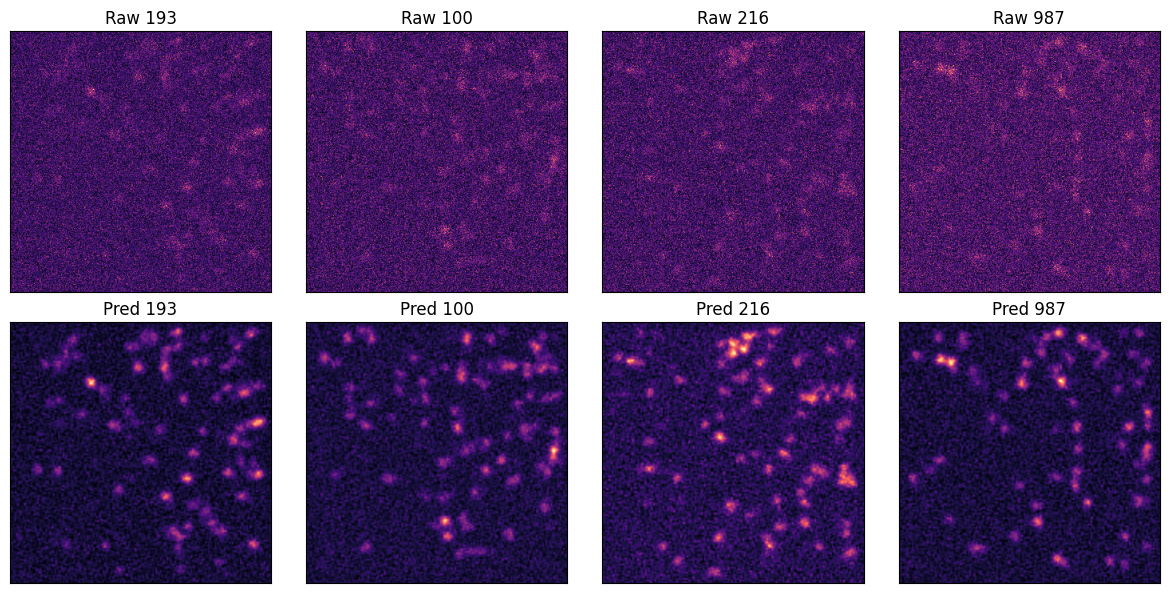

In [6]:
# Load the noisy data to be denoised
observation = imread('../../data/SDTrans/noise_200Hz_2400frames_pxlsize30nm_3.90dBSNR_24000x328x328.tif')
observation = observation[:1000]

# Load the final outcome
outcome = imread('denoised_results/mmse_results.tif')  # → (N,H,W)

# Select indices
indices = [193, 100, 216, 987]  # outcome

# Determine rows and columns
cols = 4
rows = math.ceil(len(indices) / cols) * 2

# Create figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = axes.flatten()


# Plot raw images
for i, idx in enumerate(indices):
    axes[i].imshow(observation[idx], cmap="magma")
    axes[i].set_title(f"Raw {idx}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Plot predicted images below raw images
for i, idx in enumerate(indices):
    axes[i + len(indices)].imshow(outcome[idx], cmap="magma")
    axes[i + len(indices)].set_title(f"Pred {idx}")
    axes[i + len(indices)].set_xticks([])
    axes[i + len(indices)].set_yticks([])

plt.tight_layout()
plt.show()


# Compute PSNR
Here we compute Peak Signal-to-Noise Ratio (PSNR) of the denoised MMSE output with respect to the available GT data specified by the ```gt``` parameter in the next cell. If you do not have GT data, do not run this cell.

In [7]:
PSNRs=[]
gt=np.mean(noisy_input[:,...],axis=0)[np.newaxis,...]

for i in range(len(mmse_results)):
    psnr=utils.PSNR(gt[0],mmse_results[i])
    PSNRs.append(psnr)
    print("image:", i, "psnr:"+format(psnr,".3f")+ "\t mean psnr:"+format(np.mean(PSNRs),".3f")) 
    time.sleep(0.5)
    
print('mean',np.mean(PSNRs))

NameError: name 'noisy_input' is not defined